# NLP - Topic modeling
## Wikibooks Dataset
## Goal:
A new book store is being created and they want you to suggest what categories should they categorize their English books in and to categorize the books as well.
## Description: 
This is the complete dataset of contents of all the Wikibooks in 12 languages. The content contains books of following languages: English, French, German, Spanish, Portuguese, Italian and Russian, Japanese, Dutch, Polish, Hungarian and Hebrew; each in its own directory. Wikibooks are divided into chapter and each chapter has its own webpage. This dataset can be used for tasks like Machine Translation, Text Generation, Text Parsing and Semantic Understanding of Natural Language. Body contents are provided in both new line delimited textual format as would be visible on the page along with its HTML for a better semantic parsing.
## Technologies: 
LDA; LSA; Ida2Vec, CorEx (https://github.com/gregversteeg/corex_topic)

In [ ]:
# Import libraries
import numpy as np 
import pandas as pd
import sqlite3
import ast 
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import scipy.sparse as ss
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import gensim
import gensim.corpora as corpora
import unicodedata

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import Word, TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import CoherenceModel
from gensim.models import LsiModel
from corextopic import corextopic as ct
from corextopic import vis_topic as vt
pd.options.mode.chained_assignment = None

## Import data & data exploration

In [2]:
# Create the connection
sqlConn = sqlite3.connect('wikibooks.sqlite')
sqlConn

In [3]:
# Read the data about eng books
df = pd.read_sql_query("SELECT * FROM en", sqlConn)
df.head()
sqlConn.close()

In [4]:
# Get information about the df 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86736 entries, 0 to 86735
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      86736 non-null  object
 1   url        86736 non-null  object
 2   abstract   86736 non-null  object
 3   body_text  86736 non-null  object
 4   body_html  86736 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


In [5]:
# Get descriptive stats about the df
df.describe().T

count unique                                                top  \
title      86736  86736          Wikibooks: Radiation Oncology/NHL/CLL-SLL   
url        86736  86736  https://en.wikibooks.org/wiki/Radiation_Oncolo...   
abstract   86736  62141                                                      
body_text  86736  85318  Annotations[edit | edit source]\nReferences[ed...   
body_html  86736  86736  <div class="mw-parser-output"><table width="10...   

           freq  
title         1  
url           1  
abstract   2130  
body_text   362  
body_html     1

## Missing values and duplicates

In [6]:
# Check the missing values
df.isnull().sum()

title        0
url          0
abstract     0
body_text    0
body_html    0
dtype: int64

In [7]:
# Get the number of duplicates
df.abstract.duplicated().sum()

24595

In [8]:
# Check duplicates for the abstract column
df.abstract.value_counts().head(25)

                               2130
__NOTOC__                      1498
See also                       1030
== Overview ==                  899
==Introduction==                872
__TOC__                         836
==Annotations==                 717
== Introduction ==              705
= USAGE: =                      533
<NOINCLUDE>                     398
== Basic Statistics ==          327
== Motivation ==                308
----                            296
=== Abbreviations ===           240
==Overview==                    225
}}                              218
== Synopsis ==                  218
__NOTOC__ __NOEDITSECTION__     175
==Legislation==                 173
==Contents==                    137
*..                             129
=Introduction=                  114
__NOEDITSECTION__ __NOTOC__     108
==Requirement 1==               103
== Prerequisites ==             102
Name: abstract, dtype: int64

In [9]:
# Show some of the duplicated columns abstract
duplicate_cols = df[df.abstract.duplicated()]
duplicate_cols[['title', 'abstract']]

title  \
95        Wikibooks: Shelf:Wikijunior Geography/ancestry   
101     Wikibooks: Field Guide/Birds/Agelaius phoeniceus   
102                          Wikibooks: Pinyin/Encompass   
106    Wikibooks: Annotations to James Joyce's Ulysse...   
111    Wikibooks: Muggles' Guide to Harry Potter/Char...   
...                                                  ...   
86720                     Wikibooks: Chrono Cross/Combos   
86721  Wikibooks: Dutch/Vocabulary/Survival kit/zelft...   
86729  Wikibooks: A Guidebook for Managing Telecentre...   
86730              Wikibooks: Shelf:Chemical engineering   
86735  Wikibooks: English-Hanzi/Sardine is a nutritio...   

                                                abstract  
95                                                        
101                                                       
102                                             See also  
106                                      ==Annotations==  
111                                       == Overview ==  
...                                                  ...  
86720                                         ==Combos==  
86721  Pick a word at random and say the translation ...  
86729                                        = Preface =  
86730                                                     
86735                 Sardine is a nutritious oily fish.  

[24595 rows x 2 columns]

In [10]:
# Show duplicated for the body_type column
df.body_text.value_counts().head(25)

Annotations[edit | edit source]\nReferences[edit | edit source]\n\n\n\n\nAnnotations to James Joyce's UlyssesPreceding Page | Page Index | Next Page                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [11]:
# Show first ten rows of title column
df.title.values[:10]

array(['Wikibooks: Radiation Oncology/NHL/CLL-SLL',
       'Wikibooks: Romanian/Lesson 9', 'Wikibooks: Karrigell',
       'Wikibooks: The Pyrogenesis Engine/0 A.D./GuiSession',
       'Wikibooks: LMIs in Control/pages/Exterior Conic Sector Lemma',
       'Wikibooks: Laptop Computer Models/Dell/Latitude D830',
       'Wikibooks: French/Grammar/Verbs/Present participle',
       'Wikibooks: English-Hanzi/Atherosclerosis involves inflammation',
       'Wikibooks: General Chemistry/Titration and pH',
       'Wikibooks: World Stamp Catalogue/Soviet Union/1969'], dtype=object)

In [12]:
# Show first ten rows of url
df.url.values[:10]

array(['https://en.wikibooks.org/wiki/Radiation_Oncology/NHL/CLL-SLL',
       'https://en.wikibooks.org/wiki/Romanian/Lesson_9',
       'https://en.wikibooks.org/wiki/Karrigell',
       'https://en.wikibooks.org/wiki/The_Pyrogenesis_Engine/0_A.D./GuiSession',
       'https://en.wikibooks.org/wiki/LMIs_in_Control/pages/Exterior_Conic_Sector_Lemma',
       'https://en.wikibooks.org/wiki/Laptop_Computer_Models/Dell/Latitude_D830',
       'https://en.wikibooks.org/wiki/French/Grammar/Verbs/Present_participle',
       'https://en.wikibooks.org/wiki/English-Hanzi/Atherosclerosis_involves_inflammation',
       'https://en.wikibooks.org/wiki/General_Chemistry/Titration_and_pH',
       'https://en.wikibooks.org/wiki/World_Stamp_Catalogue/Soviet_Union/1969'],
      dtype=object)

In [13]:
# Show first ten rows of abstract
df.abstract.values[:10]

array(['Chronic Lymphocytic Leukemia and Small Lymphocytic Lymphoma (CLL/SLL)',
       '==Băuturi/Beverages==',
       'Karrigell is an open Source Python web framework written in Python',
       '====setupUnitPanel====', '== The Concept ==',
       '= Dell Latitude D830 =', '==Formation==',
       'Atherosclerosis, previously thought to be a simple lipid storage disease, actually involves a continuous inflammatory response.',
       '== Ionization of Water ==', 'Почта СССР'], dtype=object)

In [14]:
# Show first ten rows of body_html
for i in df.body_html.values[:10]:
    print('New line')
    print (i)

New line
<div class="mw-parser-output"><table width="100%" style="background-color: #f2fff2; border: solid 1px #bfffbf;" cellspacing="0">

<tbody><tr valign="top">
<td>
<p><b>Front Page:</b> <a href="/wiki/Radiation_Oncology" title="Radiation Oncology">Radiation Oncology</a> | <a href="/wiki/Radiation_Oncology:RTOG_Trials" class="mw-redirect" title="Radiation Oncology:RTOG Trials">RTOG Trials</a> | <a href="/wiki/Radiation_Oncology/Randomized" title="Radiation Oncology/Randomized">Randomized Trials</a>
</p>
</td></tr>
<tr>
<td colspan="2">
<p><b>Non-Hodgkin lymphoma:</b> <a href="/wiki/Radiation_Oncology/NHL" title="Radiation Oncology/NHL">Main Page</a>  | <a href="/wiki/Radiation_Oncology/NHL/Randomized" title="Radiation Oncology/NHL/Randomized">Randomized</a>
<br><b>Overview:</b> <a href="/wiki/Radiation_Oncology/NHL/Overview" title="Radiation Oncology/NHL/Overview">Overview</a>  | 
<a href="/wiki/Radiation_Oncology/NHL/Follicular" title="Radiation Oncology/NHL/Follicular">Follicular

### Data cleaning

In [15]:
# Remove Wikibooks from the beginning of the title rows 
df['title'] = df['title'].str.replace('Wikibooks: ', '')
df

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
1                                      Romanian/Lesson 9   
2                                              Karrigell   
3               The Pyrogenesis Engine/0 A.D./GuiSession   
4      LMIs in Control/pages/Exterior Conic Sector Lemma   
...                                                  ...   
86731        Python Programming/Creating Python Programs   
86732                               Calculus/Precalculus   
86733                        Castles of England/Somerset   
86734  Digital Technology and Cultures/Interconnected...   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                     url  \
0      https://en.wikibooks.org/wiki/Radiation_Oncolo...   
1        https://en.wikibooks.org/wiki/Romanian/Lesson_9   
2                https://en.wikibooks.org/wiki/Karrigell   
3      https://en.wikibooks.org/wiki/The_Pyrogenesis_...   
4      https://en.wikibooks.org/wiki/LMIs_in_Control/...   
...                                                  ...   
86731  https://en.wikibooks.org/wiki/Python_Programmi...   
86732  https://en.wikibooks.org/wiki/Calculus/Precalc...   
86733  https://en.wikibooks.org/wiki/Castles_of_Engla...   
86734  https://en.wikibooks.org/wiki/Digital_Technolo...   
86735  https://en.wikibooks.org/wiki/English-Hanzi/Sa...   

                                                abstract  \
0      Chronic Lymphocytic Leukemia and Small Lymphoc...   
1                                  ==Băuturi/Beverages==   
2      Karrigell is an open Source Python web framewo...   
3                                 ====setupUnitPanel====   
4                                      == The Concept ==   
...                                                  ...   
86731  Welcome to Python! This tutorial will show you...   
86732                                    ==Precalculus==   
86733                  There are 11 castles in Somerset.   
86734                    =CULTURAL STUDIES AND IDENTITY=   
86735                 Sardine is a nutritious oily fish.   

                                               body_text  \
0      Front Page: Radiation Oncology | RTOG Trials |...   
1      Băuturi/Beverages[edit | edit source]\nTea : C...   
2      Karrigell is an open Source Python web framewo...   
3      setupUnitPanel[edit | edit source]\nHelper fun...   
4      Contents\n\n1 The Concept\n2 The System\n3 The...   
...                                                  ...   
86731  Previous: Self Help\n\nIndex\n\nNext: Variable...   
86732  ← Contributing\n\nCalculus\n\nAlgebra →\n\n\nP...   
86733  There are 11 castles in Somerset.\n\n\n\n\nNam...   
86734  Contents\n\n1 CULTURAL STUDIES AND IDENTITY\n\...   
86735  Sardine is a nutritious oily fish.\n沙丁鱼是一种有营养的...   

                                               body_html  
0      <div class="mw-parser-output"><table width="10...  
1      <div class="mw-parser-output"><h2><span id="B....  
2      <div class="mw-parser-output"><p>Karrigell is ...  
3      <div class="mw-parser-output"><h4><span class=...  
4      <div class="mw-parser-output"><div id="toc" cl...  
...                                                  ...  
86731  <div class="mw-parser-output"><div class="nopr...  
86732  <div class="mw-parser-output"><table width="10...  
86733  <div class="mw-parser-output"><p>There are 11 ...  
86734  <div class="mw-parser-output"><div id="toc" cl...  
86735  <div class="mw-parser-output"><p>Sardine is a ...  

[86736 rows x 5 columns]

#### Digits

In [16]:
# Extract numbers from abstract column
# Print rows with integers
df_digits_abs = df['abstract'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
for index in df_digits_abs.index:
    print(df.abstract.iloc[index])

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
C:\Users\azizbek.dzheenbekov\AppData\Local\Temp\ipykernel_15284\1768137940.py:3: DeprecationWarning: invalid escape sequence \d
  df_digits_abs = df['abstract'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)


= Dell Latitude D830 =
== Memorize and explain 2 of the following listening Bible verses==
Attention: While this is a book or tutorial about mapping and level design in GtkRadiant, which should be similar for all games that use the [tech 3|id tech 3] or [tech 4|id tech 4] engines, there are still differences like what textures or models are available etc. etc.
3.1  /Data representation/
thumb|250px|right|1: Cross section of a Fresnel lens 2: Cross section of a conventional lens of equivalent power
Q3Map2 has now been integrated with the GtkRadiant Project. Windows, Mac and Linux binaries for both 32-bit and 64-bit systems can be download from the project page.
^Lesson 5^
About 9 of 10 patients of cataract can achieve a corrected vision of 20/40 or better after surgery.
==1. Do one of the following==
In Tamil, there are 30 characters. The Tamil alphabet has 12 [and 18 consonant]s.
{|class="wikitable"  width="60%"
About half of the overall risk of Crohn's disease is related to genetics, 

{| border="1" cellpadding="2" cellspacing="0" style="border-collapse:collapse;"
thumb|400px|right|Fig - 1. Laffer curve with maximum revenue point marked out.
FIRST SERIESThe first series of the Sophismes Économiques appeared in the end of 1845; the second series in 1848.—.
|20px|border]] - English, 20px|border - Thai
== 6...
==Requirement 1==
This book will delineate the attributes of Tactical Combat and focus on a field proven methodology which effectively responds to the needs of terror interdiction teams and operators combating 4th Generation Warfare entities and tactics. The general underlying principle of this protocol involves the integration of the three combat sciences fundamental to Special Tactics expertise: Team Assault, Combat Marksmanship, and Tactical Close-Quarters Combat.
Action T4 (German: Aktion T4) was a program in Nazi Germany between 1939 and 1941, during which the regime of Adolf Hitler systematically killed between 75,000 to 100,000 people with intellectual or p

The Hobbit - Chapter 9 - Barrels Out of Bond
== Matthew 17 ==
Australian Curriculum ContentAustralian Curriculum, Assessment and Reporting Authority (ACARA), downloaded from the Australian Curriculum website on (5 October 2015).
Anna Harris was my grandmother as well as a schoolteacher from about 1910 to 1930. Her comment, which she used to make about her students, makes a good theme for this chapter—and even for teaching in general.
Westarctica (officially the Grand Duchy of Westarctica, formerly known as the Protectorate of Westarctica) is a micronation founded in 2001 by Travis McHenry. It claims the territory known as Marie Byrd Land, located between the New Zealand Antarctic Territory and the Chilean one, specifically the portion of Antarctica located between 90 degrees and 150 degrees west longitude and south of the 60th parallel.
Like humans, most Pokémon have a gender, although some of them are genderless (mainly the ones that are animate objects). Many Pokémon are either male 

f. [62v] 1    In places{es} Wher that I company2    I go sayng I lywe full merely3    yet offtymes to cloke my care and payn4    I make my contenance to be glad and fayn5    {t+r+}[[The Devonshire Manuscript/Appendix_I:_Paleographic_Features|
So far we have seen how the wars of this period had an effect however we must now have a look at the Muromachi Period more generally. The Muromachi period (室町時代 Muromachi jidai) also known as the Ashikaga period is the period of Japanese history running from 1336 to 1573.
/nav|8}}
{| border="1" cellpadding="2" cellspacing="0" style="border-collapse:collapse;"
NAVY is a tuple of value: 0.0.
Celestial map for February 15, 10:00 pm, from 30°S. South is up and North is down.
It is the people who make up the society. Here is a very small list of around 26 people
The 4013 contains two independent D-type flip-flops with asynchronous set/reset inputs. Whenever the set or reset pins go high, the appropriate output is expressed immediately on the outputs.
T

The French 75 is a cocktail of gin and champagne flavoured with lemon,
Subsection (1) states that if an estate or an interest in land is sold subject to the right of reconveyance to the vendor, or someone connected with the vendor, then the following rule applies.
Today in 1988 the CD-R specification was published. In October, the first empty CD media appeared on the market.
A caravan is defined in Paragraph 3(2) for the purposes of Paragraph 3(1) of Schedule A as having the meaning given by Section 29(1) of the Caravan Sites and Control of Development Act 1960.
|20px|border]] - Ukrainian,  20px|border - English,  20px|border - Spanish,  20px|border - Arabian
Robert Greatham Chatfield was a prominent amateur operator, amateur broadcaster, amateur club member and administrator from 1925 through at least 1955. His station callsign was 2AV (2=NZ second district, A=?
There are three main manufacturers of home video game systems; Microsoft, Sony and Nintendo.  Microsoft's currently has the 

==Section 1: Introduction to economics==
Chapter 2.  Water Policy
= 107.3 Localization and Internationalization =
map (\x -> x * 2 + 3) xs
Today in 2009 Janet Hope published Biobazaar: The Open Source Revolution and Biotechnology.
== Comparative organizational performance (alpha = 0.87) ==
A referendum on the status of Southern Rhodesia was held in the colony on 27 October 1922. Voters were given the options of establishing responsible government or joining the Union of South Africa.
thumb|right|400px|RB20DET in a S14
Honor your father and your mother is one of the Ten Commandments,Exodus 20:1-21, Deuteronomy 5:1-23, ‘’Ten Commandments,’’ New Bible Dictionary, Second Edition, Tyndale House, 1982 pp. 1174-1175 which are widely understood as moral imperatives by legal scholars, Jewish scholars, Catholic scholars, and Post-Reformation scholars.
==1==
== Performance measurement system (PMS) design for turbulence (alpha = 0.84; AVE = 0.
The L2 space is an infinite function space, and theref

In [17]:
# Remove the digits from abstract since the digits mostly do not contain any information
df['abstract'] = df['abstract'].str.replace('\d+', ' ')
df.iloc[df_digits_abs.index]

<>:2: DeprecationWarning: invalid escape sequence \d
<>:2: DeprecationWarning: invalid escape sequence \d
C:\Users\azizbek.dzheenbekov\AppData\Local\Temp\ipykernel_15284\3214409148.py:2: DeprecationWarning: invalid escape sequence \d
  df['abstract'] = df['abstract'].str.replace('\d+', ' ')
C:\Users\azizbek.dzheenbekov\AppData\Local\Temp\ipykernel_15284\3214409148.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['abstract'] = df['abstract'].str.replace('\d+', ' ')


title  \
5              Laptop Computer Models/Dell/Latitude D830   
21                 Adventist Adventurer Awards/Listening   
23                                            GtkRadiant   
25                 A-level Computing/CIE/Advanced Theory   
45                   Technical Theatre/Lighting/Fresnels   
...                                                  ...   
86697                       Salute, Jonathan!/Capitul 46   
86698                      Flora of New York/TOC-Fabales   
86700  Songbook/What shall we do with the drunken sailor   
86713          World Stamp Catalogue/United States/1970s   
86733                        Castles of England/Somerset   

                                                     url  \
5      https://en.wikibooks.org/wiki/Laptop_Computer_...   
21     https://en.wikibooks.org/wiki/Adventist_Advent...   
23              https://en.wikibooks.org/wiki/GtkRadiant   
25     https://en.wikibooks.org/wiki/A-level_Computin...   
45     https://en.wikibooks.org/wiki/Technical_Theatr...   
...                                                  ...   
86697  https://en.wikibooks.org/wiki/Salute,_Jonathan...   
86698  https://en.wikibooks.org/wiki/Flora_of_New_Yor...   
86700  https://en.wikibooks.org/wiki/Songbook/What_sh...   
86713  https://en.wikibooks.org/wiki/World_Stamp_Cata...   
86733  https://en.wikibooks.org/wiki/Castles_of_Engla...   

                                                abstract  \
5                                   = Dell Latitude D  =   
21     == Memorize and explain   of the following lis...   
23     Attention: While this is a book or tutorial ab...   
25                             .   /Data representation/   
45     thumb| px|right| : Cross section of a Fresnel ...   
...                                                  ...   
86697      Contenete - Capitul   - Capitul   - Capitul     
86698  {|class=wikitable width=" px" style="font-size...   
86700                                     \version " . .   
86713                                             == s==   
86733                   There are   castles in Somerset.   

                                               body_text  \
5      Contents\n\n1 Dell Latitude D830\n\n1.1 CPU\n1...   
21     Listening\n\n\n\n\nMulti-Level\n\nContents\n\n...   
23     Attention: While this is a book or tutorial ab...   
25     3.1  Data representation  \n3.2  Communication...   
45     Wikipedia has related information at Fresnel l...   
...                                                  ...   
86697  Contenete - Capitul 45 - Capitul 46 - Capitul ...   
86698  Clade\n\nOrder\n\nFamily\n\nSubfamily\n\nTribe...   
86700  Sea shanty – Alternative title: Drunken Sailor...   
86713  1970s[edit | edit source]\n\n\t\t\n\t\t\t\n\t\...   
86733  There are 11 castles in Somerset.\n\n\n\n\nNam...   

                                               body_html  
5      <div class="mw-parser-output"><div id="toc" cl...  
21     <div class="mw-parser-output"><table border="1...  
23     <div class="mw-parser-output"><p><b>Attention:...  
25     <div class="mw-parser-output"><p>3.1  <a href=...  
45     <div class="mw-parser-output"><table class="pl...  
...                                                  ...  
86697  <div class="mw-parser-output"><p><small><a hre...  
86698  <div class="mw-parser-output"><table class="wi...  
86700  <div class="mw-parser-output"><p><b><a href="/...  
86713  <div class="mw-parser-output"><h2><span class=...  
86733  <div class="mw-parser-output"><p>There are 11 ...  

[13837 rows x 5 columns]

#### Punctuation

In [21]:
# Remove punctiation from abstract column using regex
df['abstract'] = df['abstract'].str.replace('[^\w\s]', ' ', regex=True)
df

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
C:\Users\azizbek.dzheenbekov\AppData\Local\Temp\ipykernel_15284\1759461933.py:2: DeprecationWarning: invalid escape sequence \w
  df['abstract'] = df['abstract'].str.replace('[^\w\s]', ' ', regex=True)


title  \
0                         Radiation Oncology/NHL/CLL-SLL   
1                                      Romanian/Lesson 9   
2                                              Karrigell   
3               The Pyrogenesis Engine/0 A.D./GuiSession   
4      LMIs in Control/pages/Exterior Conic Sector Lemma   
...                                                  ...   
86731        Python Programming/Creating Python Programs   
86732                               Calculus/Precalculus   
86733                        Castles of England/Somerset   
86734  Digital Technology and Cultures/Interconnected...   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                     url  \
0      https://en.wikibooks.org/wiki/Radiation_Oncolo...   
1        https://en.wikibooks.org/wiki/Romanian/Lesson_9   
2                https://en.wikibooks.org/wiki/Karrigell   
3      https://en.wikibooks.org/wiki/The_Pyrogenesis_...   
4      https://en.wikibooks.org/wiki/LMIs_in_Control/...   
...                                                  ...   
86731  https://en.wikibooks.org/wiki/Python_Programmi...   
86732  https://en.wikibooks.org/wiki/Calculus/Precalc...   
86733  https://en.wikibooks.org/wiki/Castles_of_Engla...   
86734  https://en.wikibooks.org/wiki/Digital_Technolo...   
86735  https://en.wikibooks.org/wiki/English-Hanzi/Sa...   

                                                abstract  \
0      Chronic Lymphocytic Leukemia and Small Lymphoc...   
1                                    Băuturi Beverages     
2      Karrigell is an open Source Python web framewo...   
3                                     setupUnitPanel       
4                                         The Concept      
...                                                  ...   
86731  Welcome to Python  This tutorial will show you...   
86732                                      Precalculus     
86733                   There are   castles in Somerset    
86734                     CULTURAL STUDIES AND IDENTITY    
86735                 Sardine is a nutritious oily fish    

                                               body_text  \
0      Front Page: Radiation Oncology | RTOG Trials |...   
1      Băuturi/Beverages[edit | edit source]\nTea : C...   
2      Karrigell is an open Source Python web framewo...   
3      setupUnitPanel[edit | edit source]\nHelper fun...   
4      Contents\n\n1 The Concept\n2 The System\n3 The...   
...                                                  ...   
86731  Previous: Self Help\n\nIndex\n\nNext: Variable...   
86732  ← Contributing\n\nCalculus\n\nAlgebra →\n\n\nP...   
86733  There are 11 castles in Somerset.\n\n\n\n\nNam...   
86734  Contents\n\n1 CULTURAL STUDIES AND IDENTITY\n\...   
86735  Sardine is a nutritious oily fish.\n沙丁鱼是一种有营养的...   

                                               body_html  
0      <div class="mw-parser-output"><table width="10...  
1      <div class="mw-parser-output"><h2><span id="B....  
2      <div class="mw-parser-output"><p>Karrigell is ...  
3      <div class="mw-parser-output"><h4><span class=...  
4      <div class="mw-parser-output"><div id="toc" cl...  
...                                                  ...  
86731  <div class="mw-parser-output"><div class="nopr...  
86732  <div class="mw-parser-output"><table width="10...  
86733  <div class="mw-parser-output"><p>There are 11 ...  
86734  <div class="mw-parser-output"><div id="toc" cl...  
86735  <div class="mw-parser-output"><p>Sardine is a ...  

[86736 rows x 5 columns]

In [22]:
# Remove words less than 3 symbols
df['abstract'] = df.abstract.str.replace(r'\b(\w{1,3})\b', '', regex = True)
df

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
1                                      Romanian/Lesson 9   
2                                              Karrigell   
3               The Pyrogenesis Engine/0 A.D./GuiSession   
4      LMIs in Control/pages/Exterior Conic Sector Lemma   
...                                                  ...   
86731        Python Programming/Creating Python Programs   
86732                               Calculus/Precalculus   
86733                        Castles of England/Somerset   
86734  Digital Technology and Cultures/Interconnected...   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                     url  \
0      https://en.wikibooks.org/wiki/Radiation_Oncolo...   
1        https://en.wikibooks.org/wiki/Romanian/Lesson_9   
2                https://en.wikibooks.org/wiki/Karrigell   
3      https://en.wikibooks.org/wiki/The_Pyrogenesis_...   
4      https://en.wikibooks.org/wiki/LMIs_in_Control/...   
...                                                  ...   
86731  https://en.wikibooks.org/wiki/Python_Programmi...   
86732  https://en.wikibooks.org/wiki/Calculus/Precalc...   
86733  https://en.wikibooks.org/wiki/Castles_of_Engla...   
86734  https://en.wikibooks.org/wiki/Digital_Technolo...   
86735  https://en.wikibooks.org/wiki/English-Hanzi/Sa...   

                                                abstract  \
0      Chronic Lymphocytic Leukemia  Small Lymphocyti...   
1                                    Băuturi Beverages     
2      Karrigell   open Source Python  framework writ...   
3                                     setupUnitPanel       
4                                             Concept      
...                                                  ...   
86731  Welcome  Python  This tutorial will show    st...   
86732                                      Precalculus     
86733                        There    castles  Somerset    
86734                        CULTURAL STUDIES  IDENTITY    
86735                    Sardine   nutritious oily fish    

                                               body_text  \
0      Front Page: Radiation Oncology | RTOG Trials |...   
1      Băuturi/Beverages[edit | edit source]\nTea : C...   
2      Karrigell is an open Source Python web framewo...   
3      setupUnitPanel[edit | edit source]\nHelper fun...   
4      Contents\n\n1 The Concept\n2 The System\n3 The...   
...                                                  ...   
86731  Previous: Self Help\n\nIndex\n\nNext: Variable...   
86732  ← Contributing\n\nCalculus\n\nAlgebra →\n\n\nP...   
86733  There are 11 castles in Somerset.\n\n\n\n\nNam...   
86734  Contents\n\n1 CULTURAL STUDIES AND IDENTITY\n\...   
86735  Sardine is a nutritious oily fish.\n沙丁鱼是一种有营养的...   

                                               body_html  
0      <div class="mw-parser-output"><table width="10...  
1      <div class="mw-parser-output"><h2><span id="B....  
2      <div class="mw-parser-output"><p>Karrigell is ...  
3      <div class="mw-parser-output"><h4><span class=...  
4      <div class="mw-parser-output"><div id="toc" cl...  
...                                                  ...  
86731  <div class="mw-parser-output"><div class="nopr...  
86732  <div class="mw-parser-output"><table width="10...  
86733  <div class="mw-parser-output"><p>There are 11 ...  
86734  <div class="mw-parser-output"><div id="toc" cl...  
86735  <div class="mw-parser-output"><p>Sardine is a ...  

[86736 rows x 5 columns]

#### Stopwords

In [23]:
# Create variable to contain stopwords
stopwords_abs = stopwords.words('english')
stopwords_abs

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

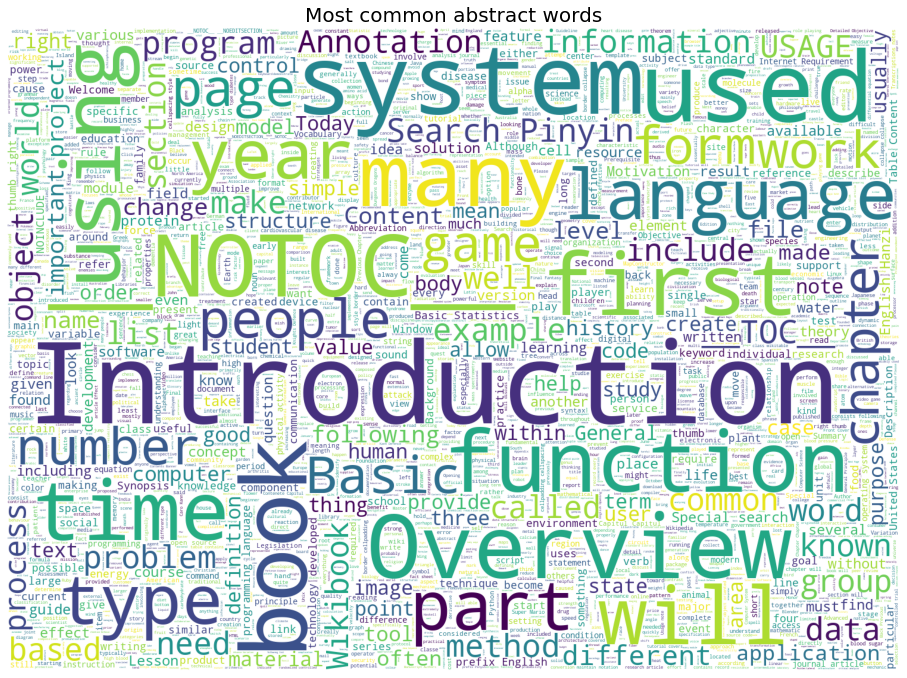

In [21]:
# Wordcloud to check the most used words and add appropriate ones to the stopwords list
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

plt.subplots(figsize=(16,13))
wordcloud = WordCloud(
                          background_color='white',max_words = 10000, width=1500, stopwords=STOPWORDS,
                          height=1080).generate(" ".join(df.abstract))
plt.title("Most common abstract words", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis'))
plt.axis('off')
plt.show()

In [24]:
# Adding some of the words to the stopwords list 
stopwords_to_remove = ['Introduction', 'language', 'overview', 'book', 'year', 'page', 'function', 'type',
                     'many', 'data', 'content', 'used', 'using', 'work', 'time', 'word', 'part', 'system',
                     'example', 'called', 'application','annotation','Wikibook','list','process','text',
                     'body','information','problem','special','following', '__NOTOC__','object','Basic', 
                      'Today', 'based','make','form','section','important','name','world','known','need',
                     'number','common','Annotations','first', 'chapter','also','__TOC__','group','General','provide',
                     'well','USAGE','Search', 'also','people', 'different' 'program']
stopwords_abs.extend(stopwords_to_remove)

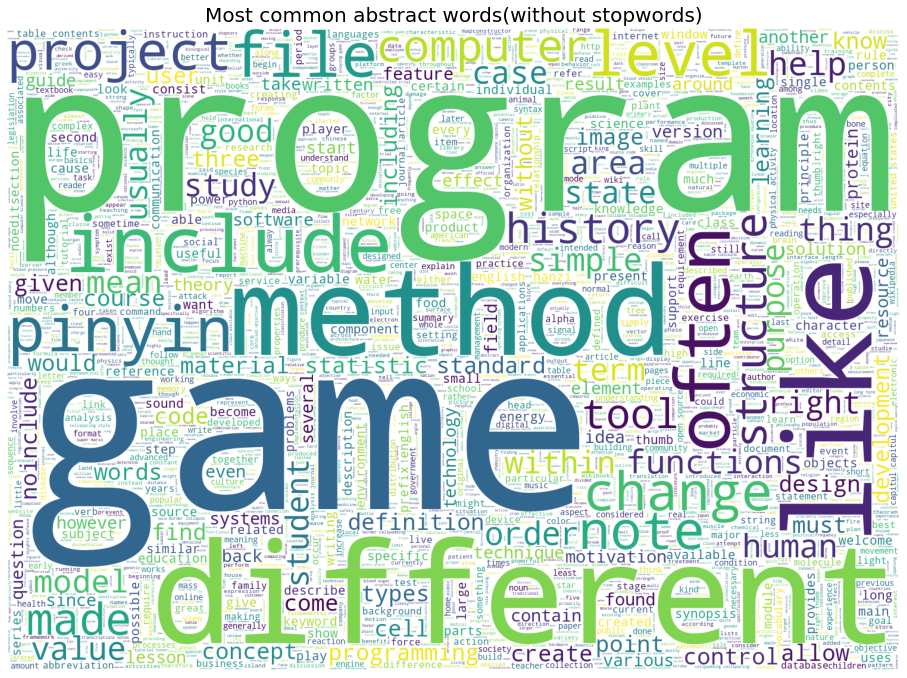

In [99]:
# Create Wordcloud with removed stopwords
plt.subplots(figsize=(16,13))
wordcloud = WordCloud(
                          background_color='white',max_words = 10000, width=1500, stopwords=stopwords_abs,
                          height=1080).generate(" ".join(df.abstract))
plt.title("Most common abstract words(without stopwords)", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis'))
plt.axis('off')
plt.show()

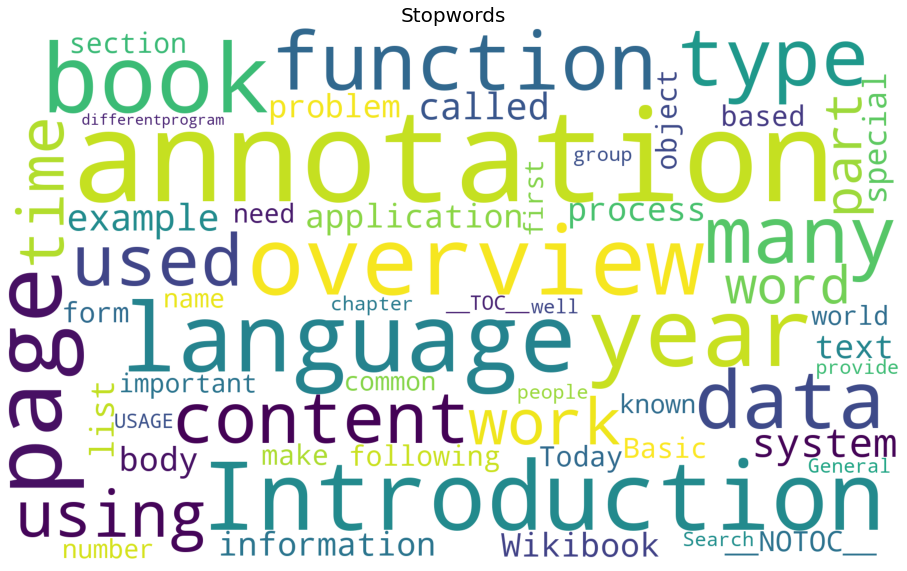

In [100]:
# Wordcloud with stopwords that were removed
plt.subplots(figsize=(16,13))
wordcloud = WordCloud(
                          background_color='white', width=1800,
                          height=1080).generate(" ".join(stopwords_to_remove))
plt.title("Stopwords", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis'))
plt.axis('off')
plt.show()

In [25]:
# Remove the stopwords from the abstract column 
df['abstract'] = df['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word 
                                                      not in (stopwords_abs)]))
df

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
1                                      Romanian/Lesson 9   
2                                              Karrigell   
3               The Pyrogenesis Engine/0 A.D./GuiSession   
4      LMIs in Control/pages/Exterior Conic Sector Lemma   
...                                                  ...   
86731        Python Programming/Creating Python Programs   
86732                               Calculus/Precalculus   
86733                        Castles of England/Somerset   
86734  Digital Technology and Cultures/Interconnected...   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                     url  \
0      https://en.wikibooks.org/wiki/Radiation_Oncolo...   
1        https://en.wikibooks.org/wiki/Romanian/Lesson_9   
2                https://en.wikibooks.org/wiki/Karrigell   
3      https://en.wikibooks.org/wiki/The_Pyrogenesis_...   
4      https://en.wikibooks.org/wiki/LMIs_in_Control/...   
...                                                  ...   
86731  https://en.wikibooks.org/wiki/Python_Programmi...   
86732  https://en.wikibooks.org/wiki/Calculus/Precalc...   
86733  https://en.wikibooks.org/wiki/Castles_of_Engla...   
86734  https://en.wikibooks.org/wiki/Digital_Technolo...   
86735  https://en.wikibooks.org/wiki/English-Hanzi/Sa...   

                                                abstract  \
0      Chronic Lymphocytic Leukemia Small Lymphocytic...   
1                                      Băuturi Beverages   
2      Karrigell open Source Python framework written...   
3                                         setupUnitPanel   
4                                                Concept   
...                                                  ...   
86731  Welcome Python This tutorial show start writin...   
86732                                        Precalculus   
86733                             There castles Somerset   
86734                          CULTURAL STUDIES IDENTITY   
86735                       Sardine nutritious oily fish   

                                               body_text  \
0      Front Page: Radiation Oncology | RTOG Trials |...   
1      Băuturi/Beverages[edit | edit source]\nTea : C...   
2      Karrigell is an open Source Python web framewo...   
3      setupUnitPanel[edit | edit source]\nHelper fun...   
4      Contents\n\n1 The Concept\n2 The System\n3 The...   
...                                                  ...   
86731  Previous: Self Help\n\nIndex\n\nNext: Variable...   
86732  ← Contributing\n\nCalculus\n\nAlgebra →\n\n\nP...   
86733  There are 11 castles in Somerset.\n\n\n\n\nNam...   
86734  Contents\n\n1 CULTURAL STUDIES AND IDENTITY\n\...   
86735  Sardine is a nutritious oily fish.\n沙丁鱼是一种有营养的...   

                                               body_html  
0      <div class="mw-parser-output"><table width="10...  
1      <div class="mw-parser-output"><h2><span id="B....  
2      <div class="mw-parser-output"><p>Karrigell is ...  
3      <div class="mw-parser-output"><h4><span class=...  
4      <div class="mw-parser-output"><div id="toc" cl...  
...                                                  ...  
86731  <div class="mw-parser-output"><div class="nopr...  
86732  <div class="mw-parser-output"><table width="10...  
86733  <div class="mw-parser-output"><p>There are 11 ...  
86734  <div class="mw-parser-output"><div id="toc" cl...  
86735  <div class="mw-parser-output"><p>Sardine is a ...  

[86736 rows x 5 columns]

#### Remove non-english words

In [26]:
# Replace non english characters
def replace_char(str):
    out = unicodedata.normalize('NFKD', str).encode('ascii','ignore').decode('utf-8','ignore')
    return out
df['abstract'] = df['abstract'].apply(replace_char)

In [27]:
# Check the ascii characters
df[df['abstract'].map(lambda x: x.isascii())]
df

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
1                                      Romanian/Lesson 9   
2                                              Karrigell   
3               The Pyrogenesis Engine/0 A.D./GuiSession   
4      LMIs in Control/pages/Exterior Conic Sector Lemma   
...                                                  ...   
86731        Python Programming/Creating Python Programs   
86732                               Calculus/Precalculus   
86733                        Castles of England/Somerset   
86734  Digital Technology and Cultures/Interconnected...   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                     url  \
0      https://en.wikibooks.org/wiki/Radiation_Oncolo...   
1        https://en.wikibooks.org/wiki/Romanian/Lesson_9   
2                https://en.wikibooks.org/wiki/Karrigell   
3      https://en.wikibooks.org/wiki/The_Pyrogenesis_...   
4      https://en.wikibooks.org/wiki/LMIs_in_Control/...   
...                                                  ...   
86731  https://en.wikibooks.org/wiki/Python_Programmi...   
86732  https://en.wikibooks.org/wiki/Calculus/Precalc...   
86733  https://en.wikibooks.org/wiki/Castles_of_Engla...   
86734  https://en.wikibooks.org/wiki/Digital_Technolo...   
86735  https://en.wikibooks.org/wiki/English-Hanzi/Sa...   

                                                abstract  \
0      Chronic Lymphocytic Leukemia Small Lymphocytic...   
1                                      Bauturi Beverages   
2      Karrigell open Source Python framework written...   
3                                         setupUnitPanel   
4                                                Concept   
...                                                  ...   
86731  Welcome Python This tutorial show start writin...   
86732                                        Precalculus   
86733                             There castles Somerset   
86734                          CULTURAL STUDIES IDENTITY   
86735                       Sardine nutritious oily fish   

                                               body_text  \
0      Front Page: Radiation Oncology | RTOG Trials |...   
1      Băuturi/Beverages[edit | edit source]\nTea : C...   
2      Karrigell is an open Source Python web framewo...   
3      setupUnitPanel[edit | edit source]\nHelper fun...   
4      Contents\n\n1 The Concept\n2 The System\n3 The...   
...                                                  ...   
86731  Previous: Self Help\n\nIndex\n\nNext: Variable...   
86732  ← Contributing\n\nCalculus\n\nAlgebra →\n\n\nP...   
86733  There are 11 castles in Somerset.\n\n\n\n\nNam...   
86734  Contents\n\n1 CULTURAL STUDIES AND IDENTITY\n\...   
86735  Sardine is a nutritious oily fish.\n沙丁鱼是一种有营养的...   

                                               body_html  
0      <div class="mw-parser-output"><table width="10...  
1      <div class="mw-parser-output"><h2><span id="B....  
2      <div class="mw-parser-output"><p>Karrigell is ...  
3      <div class="mw-parser-output"><h4><span class=...  
4      <div class="mw-parser-output"><div id="toc" cl...  
...                                                  ...  
86731  <div class="mw-parser-output"><div class="nopr...  
86732  <div class="mw-parser-output"><table width="10...  
86733  <div class="mw-parser-output"><p>There are 11 ...  
86734  <div class="mw-parser-output"><div id="toc" cl...  
86735  <div class="mw-parser-output"><p>Sardine is a ...  

[86736 rows x 5 columns]

In [28]:
# Remove whitespaces
df['abstract'].str.strip()
df

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
1                                      Romanian/Lesson 9   
2                                              Karrigell   
3               The Pyrogenesis Engine/0 A.D./GuiSession   
4      LMIs in Control/pages/Exterior Conic Sector Lemma   
...                                                  ...   
86731        Python Programming/Creating Python Programs   
86732                               Calculus/Precalculus   
86733                        Castles of England/Somerset   
86734  Digital Technology and Cultures/Interconnected...   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                     url  \
0      https://en.wikibooks.org/wiki/Radiation_Oncolo...   
1        https://en.wikibooks.org/wiki/Romanian/Lesson_9   
2                https://en.wikibooks.org/wiki/Karrigell   
3      https://en.wikibooks.org/wiki/The_Pyrogenesis_...   
4      https://en.wikibooks.org/wiki/LMIs_in_Control/...   
...                                                  ...   
86731  https://en.wikibooks.org/wiki/Python_Programmi...   
86732  https://en.wikibooks.org/wiki/Calculus/Precalc...   
86733  https://en.wikibooks.org/wiki/Castles_of_Engla...   
86734  https://en.wikibooks.org/wiki/Digital_Technolo...   
86735  https://en.wikibooks.org/wiki/English-Hanzi/Sa...   

                                                abstract  \
0      Chronic Lymphocytic Leukemia Small Lymphocytic...   
1                                      Bauturi Beverages   
2      Karrigell open Source Python framework written...   
3                                         setupUnitPanel   
4                                                Concept   
...                                                  ...   
86731  Welcome Python This tutorial show start writin...   
86732                                        Precalculus   
86733                             There castles Somerset   
86734                          CULTURAL STUDIES IDENTITY   
86735                       Sardine nutritious oily fish   

                                               body_text  \
0      Front Page: Radiation Oncology | RTOG Trials |...   
1      Băuturi/Beverages[edit | edit source]\nTea : C...   
2      Karrigell is an open Source Python web framewo...   
3      setupUnitPanel[edit | edit source]\nHelper fun...   
4      Contents\n\n1 The Concept\n2 The System\n3 The...   
...                                                  ...   
86731  Previous: Self Help\n\nIndex\n\nNext: Variable...   
86732  ← Contributing\n\nCalculus\n\nAlgebra →\n\n\nP...   
86733  There are 11 castles in Somerset.\n\n\n\n\nNam...   
86734  Contents\n\n1 CULTURAL STUDIES AND IDENTITY\n\...   
86735  Sardine is a nutritious oily fish.\n沙丁鱼是一种有营养的...   

                                               body_html  
0      <div class="mw-parser-output"><table width="10...  
1      <div class="mw-parser-output"><h2><span id="B....  
2      <div class="mw-parser-output"><p>Karrigell is ...  
3      <div class="mw-parser-output"><h4><span class=...  
4      <div class="mw-parser-output"><div id="toc" cl...  
...                                                  ...  
86731  <div class="mw-parser-output"><div class="nopr...  
86732  <div class="mw-parser-output"><table width="10...  
86733  <div class="mw-parser-output"><p>There are 11 ...  
86734  <div class="mw-parser-output"><div id="toc" cl...  
86735  <div class="mw-parser-output"><p>Sardine is a ...  

[86736 rows x 5 columns]

In [29]:
# Put abstract column to lowercase
df['abstract'] = df['abstract'].str.lower()
df

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
1                                      Romanian/Lesson 9   
2                                              Karrigell   
3               The Pyrogenesis Engine/0 A.D./GuiSession   
4      LMIs in Control/pages/Exterior Conic Sector Lemma   
...                                                  ...   
86731        Python Programming/Creating Python Programs   
86732                               Calculus/Precalculus   
86733                        Castles of England/Somerset   
86734  Digital Technology and Cultures/Interconnected...   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                     url  \
0      https://en.wikibooks.org/wiki/Radiation_Oncolo...   
1        https://en.wikibooks.org/wiki/Romanian/Lesson_9   
2                https://en.wikibooks.org/wiki/Karrigell   
3      https://en.wikibooks.org/wiki/The_Pyrogenesis_...   
4      https://en.wikibooks.org/wiki/LMIs_in_Control/...   
...                                                  ...   
86731  https://en.wikibooks.org/wiki/Python_Programmi...   
86732  https://en.wikibooks.org/wiki/Calculus/Precalc...   
86733  https://en.wikibooks.org/wiki/Castles_of_Engla...   
86734  https://en.wikibooks.org/wiki/Digital_Technolo...   
86735  https://en.wikibooks.org/wiki/English-Hanzi/Sa...   

                                                abstract  \
0      chronic lymphocytic leukemia small lymphocytic...   
1                                      bauturi beverages   
2      karrigell open source python framework written...   
3                                         setupunitpanel   
4                                                concept   
...                                                  ...   
86731  welcome python this tutorial show start writin...   
86732                                        precalculus   
86733                             there castles somerset   
86734                          cultural studies identity   
86735                       sardine nutritious oily fish   

                                               body_text  \
0      Front Page: Radiation Oncology | RTOG Trials |...   
1      Băuturi/Beverages[edit | edit source]\nTea : C...   
2      Karrigell is an open Source Python web framewo...   
3      setupUnitPanel[edit | edit source]\nHelper fun...   
4      Contents\n\n1 The Concept\n2 The System\n3 The...   
...                                                  ...   
86731  Previous: Self Help\n\nIndex\n\nNext: Variable...   
86732  ← Contributing\n\nCalculus\n\nAlgebra →\n\n\nP...   
86733  There are 11 castles in Somerset.\n\n\n\n\nNam...   
86734  Contents\n\n1 CULTURAL STUDIES AND IDENTITY\n\...   
86735  Sardine is a nutritious oily fish.\n沙丁鱼是一种有营养的...   

                                               body_html  
0      <div class="mw-parser-output"><table width="10...  
1      <div class="mw-parser-output"><h2><span id="B....  
2      <div class="mw-parser-output"><p>Karrigell is ...  
3      <div class="mw-parser-output"><h4><span class=...  
4      <div class="mw-parser-output"><div id="toc" cl...  
...                                                  ...  
86731  <div class="mw-parser-output"><div class="nopr...  
86732  <div class="mw-parser-output"><table width="10...  
86733  <div class="mw-parser-output"><p>There are 11 ...  
86734  <div class="mw-parser-output"><div id="toc" cl...  
86735  <div class="mw-parser-output"><p>Sardine is a ...  

[86736 rows x 5 columns]

#### Noise data

In [30]:
# Create new columns based on length
df['abstract_length'] = df['abstract'].apply(len)
df['body_text_length'] = df['body_text'].apply(len)
df["number_words_abstract"] = df["abstract"].apply(lambda x: len(x.split()))
df[['title', 'abstract','body_text','abstract_length', 'body_text_length','number_words_abstract']]

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
1                                      Romanian/Lesson 9   
2                                              Karrigell   
3               The Pyrogenesis Engine/0 A.D./GuiSession   
4      LMIs in Control/pages/Exterior Conic Sector Lemma   
...                                                  ...   
86731        Python Programming/Creating Python Programs   
86732                               Calculus/Precalculus   
86733                        Castles of England/Somerset   
86734  Digital Technology and Cultures/Interconnected...   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                abstract  \
0      chronic lymphocytic leukemia small lymphocytic...   
1                                      bauturi beverages   
2      karrigell open source python framework written...   
3                                         setupunitpanel   
4                                                concept   
...                                                  ...   
86731  welcome python this tutorial show start writin...   
86732                                        precalculus   
86733                             there castles somerset   
86734                          cultural studies identity   
86735                       sardine nutritious oily fish   

                                               body_text  abstract_length  \
0      Front Page: Radiation Oncology | RTOG Trials |...               55   
1      Băuturi/Beverages[edit | edit source]\nTea : C...               17   
2      Karrigell is an open Source Python web framewo...               53   
3      setupUnitPanel[edit | edit source]\nHelper fun...               14   
4      Contents\n\n1 The Concept\n2 The System\n3 The...                7   
...                                                  ...              ...   
86731  Previous: Self Help\n\nIndex\n\nNext: Variable...               56   
86732  ← Contributing\n\nCalculus\n\nAlgebra →\n\n\nP...               11   
86733  There are 11 castles in Somerset.\n\n\n\n\nNam...               22   
86734  Contents\n\n1 CULTURAL STUDIES AND IDENTITY\n\...               25   
86735  Sardine is a nutritious oily fish.\n沙丁鱼是一种有营养的...               28   

       body_text_length  number_words_abstract  
0                  4805                      6  
1                   827                      2  
2                  1250                      7  
3                   185                      1  
4                 11040                      1  
...                 ...                    ...  
86731              6672                      8  
86732               428                      1  
86733              1646                      3  
86734              8429                      3  
86735                49                      4  

[86736 rows x 6 columns]

In [31]:
# Check values in the abstract length column
df['abstract_length'].value_counts()

0      11796
8       3251
10      2618
7       2267
11      1979
       ...  
342        1
447        1
422        1
688        1
430        1
Name: abstract_length, Length: 471, dtype: int64

In [32]:
# Get values that are too long
long_abstract = np.percentile(df['number_words_abstract'], 99.7)
long_abstract

40.0

In [33]:
# Keep the long values since values can give more precise modelling for us
df[df['number_words_abstract'] > long_abstract].count()

title                    253
url                      253
abstract                 253
body_text                253
body_html                253
abstract_length          253
body_text_length         253
number_words_abstract    253
dtype: int64

In [34]:
# Get values that are too short
short_abstract = np.percentile(df['number_words_abstract'], 10)
short_abstract

0.0

In [35]:
# The minimum amount will be three words, since column that contain only one word is not enough
short_abstract = 3

In [36]:
# Remove values that are too short
df[df['number_words_abstract'] < short_abstract].count()

title                    41833
url                      41833
abstract                 41833
body_text                41833
body_html                41833
abstract_length          41833
body_text_length         41833
number_words_abstract    41833
dtype: int64

In [37]:
# Remove columns that have too short abstract
df_cleaned = df.copy()
df_cleaned = df[(df['number_words_abstract'] > short_abstract)]
df_cleaned

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                     url  \
0      https://en.wikibooks.org/wiki/Radiation_Oncolo...   
2                https://en.wikibooks.org/wiki/Karrigell   
7      https://en.wikibooks.org/wiki/English-Hanzi/At...   
10     https://en.wikibooks.org/wiki/A_Researcher%27s...   
11     https://en.wikibooks.org/wiki/Exercise_as_it_r...   
...                                                  ...   
86726  https://en.wikibooks.org/wiki/Geography_of_Rac...   
86727  https://en.wikibooks.org/wiki/Semiconductor_El...   
86728  https://en.wikibooks.org/wiki/Life_in_the_Open...   
86731  https://en.wikibooks.org/wiki/Python_Programmi...   
86735  https://en.wikibooks.org/wiki/English-Hanzi/Sa...   

                                                abstract  \
0      chronic lymphocytic leukemia small lymphocytic...   
2      karrigell open source python framework written...   
7      atherosclerosis previously thought simple lipi...   
10     this resource book local history techniques te...   
11     this wikibooks fact sheet analysis article hab...   
...                                                  ...   
86726  this explores spatial distribution racial grou...   
86727  field effect transistors device find applicati...   
86728  inquiry oriented activity learners interact co...   
86731  welcome python this tutorial show start writin...   
86735                       sardine nutritious oily fish   

                                               body_text  \
0      Front Page: Radiation Oncology | RTOG Trials |...   
2      Karrigell is an open Source Python web framewo...   
7      Atherosclerosis, previously thought to be a si...   
10     Contents\n\n1 Abecedary (a list of definitions...   
11     This Wikibooks page is a fact sheet and analys...   
...                                                  ...   
86726  This Wikibook explores the spatial distributio...   
86727  FET or Field effect transistors are device tha...   
86728  Webquest is an inquiry-oriented activity in wh...   
86731  Previous: Self Help\n\nIndex\n\nNext: Variable...   
86735  Sardine is a nutritious oily fish.\n沙丁鱼是一种有营养的...   

                                               body_html  abstract_length  \
0      <div class="mw-parser-output"><table width="10...               55   
2      <div class="mw-parser-output"><p>Karrigell is ...               53   
7      <div class="mw-parser-output"><p>Atheroscleros...              114   
10     <div class="mw-parser-output"><table cellspaci...              305   
11     <div class="mw-parser-output"><p>This Wikibook...              147   
...                                                  ...              ...   
86726  <div class="mw-parser-output"><p>This Wikibook...              284   
86727  <div class="mw-parser-output"><p>FET or Field ...              134   
86728  <div class="mw-parser-output"><p><a href="http...               68   
86731  <div class="mw-parser-output"><div class="nopr...               56   
86735  <div class="mw-parser-output"><p>Sardine is a ...               28   

       body_text_length  number_words_abstract  
0                  4805                      6  
2                  1250                      7  
7                   166                     12  
10                 4408                     40

In [38]:
# Check for duplicates
df_cleaned.duplicated().sum()

0

In [39]:
# Delete not needed columns after column cleaning 
df_cleaned.drop('body_text', inplace=True, axis=1)
df_cleaned.drop('body_html', inplace=True, axis=1)
df_cleaned.drop('url', inplace=True, axis=1)

df_cleaned

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                abstract  abstract_length  \
0      chronic lymphocytic leukemia small lymphocytic...               55   
2      karrigell open source python framework written...               53   
7      atherosclerosis previously thought simple lipi...              114   
10     this resource book local history techniques te...              305   
11     this wikibooks fact sheet analysis article hab...              147   
...                                                  ...              ...   
86726  this explores spatial distribution racial grou...              284   
86727  field effect transistors device find applicati...              134   
86728  inquiry oriented activity learners interact co...               68   
86731  welcome python this tutorial show start writin...               56   
86735                       sardine nutritious oily fish               28   

       body_text_length  number_words_abstract  
0                  4805                      6  
2                  1250                      7  
7                   166                     12  
10                 4408                     40  
11                 8527                     18  
...                 ...                    ...  
86726              1411                     32  
86727              1493                     17  
86728               284                      8  
86731              6672                      8  
86735                49                      4  

[37552 rows x 5 columns]

### Lemmatize

In [40]:
# Lemmatize using Word library
df_cleaned['abstract_lemmatized'] = df_cleaned.abstract.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df_cleaned

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                abstract  abstract_length  \
0      chronic lymphocytic leukemia small lymphocytic...               55   
2      karrigell open source python framework written...               53   
7      atherosclerosis previously thought simple lipi...              114   
10     this resource book local history techniques te...              305   
11     this wikibooks fact sheet analysis article hab...              147   
...                                                  ...              ...   
86726  this explores spatial distribution racial grou...              284   
86727  field effect transistors device find applicati...              134   
86728  inquiry oriented activity learners interact co...               68   
86731  welcome python this tutorial show start writin...               56   
86735                       sardine nutritious oily fish               28   

       body_text_length  number_words_abstract  \
0                  4805                      6   
2                  1250                      7   
7                   166                     12   
10                 4408                     40   
11                 8527                     18   
...                 ...                    ...   
86726              1411                     32   
86727              1493                     17   
86728               284                      8   
86731              6672                      8   
86735                49                      4   

                                     abstract_lemmatized  
0      chronic lymphocytic leukemia small lymphocytic...  
2      karrigell open source python framework written...  
7      atherosclerosis previously thought simple lipi...  
10     this resource book local history technique ter...  
11     this wikibooks fact sheet analysis article hab...  
...                                                  ...  
86726  this explores spatial distribution racial grou...  
86727  field effect transistor device find applicatio...  
86728  inquiry oriented activity learner interact com...  
86731  welcome python this tutorial show start writin...  
86735                       sardine nutritious oily fish  

[37552 rows x 6 columns]

### Tokenize

In [41]:
# Tokenize the text using textBlob
df_cleaned["abstract_tokenized"] = df_cleaned["abstract"].apply(lambda x: TextBlob(x).words)
df_cleaned

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                abstract  abstract_length  \
0      chronic lymphocytic leukemia small lymphocytic...               55   
2      karrigell open source python framework written...               53   
7      atherosclerosis previously thought simple lipi...              114   
10     this resource book local history techniques te...              305   
11     this wikibooks fact sheet analysis article hab...              147   
...                                                  ...              ...   
86726  this explores spatial distribution racial grou...              284   
86727  field effect transistors device find applicati...              134   
86728  inquiry oriented activity learners interact co...               68   
86731  welcome python this tutorial show start writin...               56   
86735                       sardine nutritious oily fish               28   

       body_text_length  number_words_abstract  \
0                  4805                      6   
2                  1250                      7   
7                   166                     12   
10                 4408                     40   
11                 8527                     18   
...                 ...                    ...   
86726              1411                     32   
86727              1493                     17   
86728               284                      8   
86731              6672                      8   
86735                49                      4   

                                     abstract_lemmatized  \
0      chronic lymphocytic leukemia small lymphocytic...   
2      karrigell open source python framework written...   
7      atherosclerosis previously thought simple lipi...   
10     this resource book local history technique ter...   
11     this wikibooks fact sheet analysis article hab...   
...                                                  ...   
86726  this explores spatial distribution racial grou...   
86727  field effect transistor device find applicatio...   
86728  inquiry oriented activity learner interact com...   
86731  welcome python this tutorial show start writin...   
86735                       sardine nutritious oily fish   

                                      abstract_tokenized  
0      [chronic, lymphocytic, leukemia, small, lympho...  
2      [karrigell, open, source, python, framework, w...  
7      [atherosclerosis, previously, thought, simple,...  
10     [this, resource, book, local, history, techniq...  
11     [this, wikibooks, fact, sheet, analysis, artic...  
...                                                  ...  
86726  [this, explores, spatial, distribution, racial...  
86727  [field, effect, transistors, device, find, app...  
86728  [inquiry, oriented, activity, learners, intera...  
86731  [welcome, python, this, tutorial, show, start,...  
86735                  [sardine, nutritious, oily, fish]  

[37552 rows x 7 columns]

In [42]:
# Save preprocessed df
df_cleaned.to_csv('data/df_cleaned.csv')

### Vectorization

#### Count vectorizer

In [43]:
# Create vectorized abstract column, corpus of vectorized, list of words and dictinary
abstract = df_cleaned['abstract_lemmatized']

vect = CountVectorizer(min_df=20, max_df=0.5) 
abstract_vectorized = vect.fit_transform(abstract) #vectorized column

corpus_vect = gensim.matutils.Sparse2Corpus(abstract_vectorized, documents_columns=False) #create corpus
words_vect = list(np.asarray(vect.get_feature_names_out())) #create list of words 

id_map = dict((v, k) for k, v in vect.vocabulary_.items()) #create dictionary for the items
id_map

{512: 'chronic',
 2922: 'small',
 2200: 'open',
 2958: 'source',
 2533: 'python',
 1339: 'framework',
 3493: 'written',
 2446: 'previously',
 3208: 'thought',
 2894: 'simple',
 1855: 'lipid',
 3036: 'storage',
 922: 'disease',
 44: 'actually',
 1715: 'involves',
 685: 'continuous',
 1632: 'inflammatory',
 2700: 'response',
 3204: 'this',
 2696: 'resource',
 351: 'book',
 1872: 'local',
 1534: 'history',
 3155: 'technique',
 3173: 'terminology',
 85: 'aimed',
 1512: 'helping',
 2690: 'researcher',
 3066: 'studying',
 1532: 'historical',
 942: 'document',
 671: 'contain',
 3171: 'term',
 2090: 'name',
 2366: 'plant',
 136: 'animal',
 882: 'dialect',
 3480: 'word',
 1070: 'english',
 120: 'american',
 3337: 'unusual',
 1823: 'legal',
 2566: 'rarely',
 3453: 'wikibooks',
 1204: 'fact',
 2863: 'sheet',
 126: 'analysis',
 193: 'article',
 2348: 'physical',
 41: 'activity',
 497: 'child',
 58: 'adolescent',
 1241: 'fibrosis',
 1150: 'exercise',
 2635: 'related',
 3443: 'while',
 1556: 'human'

In [44]:
# Create list of words, dictionary for the list and corpus of words
word_tokens = abstract.apply(lambda x: x.split()).tolist() #list of words
id2word = corpora.Dictionary(word_tokens) #dictionary from the list
corpus = [id2word.doc2bow(token) for token in word_tokens] #corpus of words

#### TF_IDF

In [45]:
# Fit abstract with TFIDF
# Create transformed var 
tfv = TfidfVectorizer(min_df=13, max_df=0.4) 
tfv_fit = tfv.fit(abstract)
tfv_transform = tfv_fit.transform(abstract)

print(tfv_transform.shape)
print(tfv_transform[3])

(37552, 4813)
  (0, 4766)	0.24906895386357442
  (0, 4559)	0.182428194595173
  (0, 4373)	0.06867033795646356
  (0, 4331)	0.17505755160919625
  (0, 4329)	0.34572737176769486
  (0, 4305)	0.1268911762710959
  (0, 4177)	0.1585269000374396
  (0, 3693)	0.12483067043465523
  (0, 3684)	0.16823470384509961
  (0, 3524)	0.1849490555902501
  (0, 3240)	0.12580589745166065
  (0, 2860)	0.2813406216342007
  (0, 2561)	0.43483713096669285
  (0, 2496)	0.16403971894171043
  (0, 2107)	0.2422111590327515
  (0, 2105)	0.1620464037019409
  (0, 2078)	0.18164763017639082
  (0, 1686)	0.1963117603348543
  (0, 1492)	0.10658803178882915
  (0, 1313)	0.13577979985573163
  (0, 1232)	0.1713855500975676
  (0, 942)	0.14436413985186144
  (0, 489)	0.13597578177017497
  (0, 202)	0.13891792445878456
  (0, 179)	0.1336420077432445
  (0, 128)	0.16547530111735234


In [46]:
# Get the names of features as array
words_tf = np.array(tfv.get_feature_names_out())
print(words_tf)

['_paleographic_features' 'abbreviated' 'abdomen' ... 'zone' 'zuerich'
 'zurich']


## Create test model 

In [47]:
# Model with 30 topics
unsup_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, passes=10,
                                               random_state=100, num_topics=30, workers=4)

In [48]:
# Get the topics
unsup_model.show_topics(num_topics = 30, num_words=10, formatted=False)

[(0,
  [('group', 0.023230683),
   ('disorder', 0.014125829),
   ('stage', 0.01305399),
   ('symptom', 0.012634285),
   ('cause', 0.008199861),
   ('mental', 0.008121974),
   ('long', 0.007107104),
   ('usually', 0.0067956303),
   ('life', 0.0065429965),
   ('death', 0.006510642)]),
 (1,
  [('project', 0.013783554),
   ('design', 0.0133943455),
   ('this', 0.012388051),
   ('function', 0.012184082),
   ('management', 0.011376879),
   ('type', 0.010948348),
   ('different', 0.009591941),
   ('product', 0.009402861),
   ('model', 0.008310478),
   ('element', 0.008252692)]),
 (2,
  [('energy', 0.027955502),
   ('mass', 0.024580035),
   ('vehicle', 0.008584054),
   ('charge', 0.0076341922),
   ('road', 0.006471938),
   ('society', 0.005499686),
   ('spectrometry', 0.0054470305),
   ('matter', 0.005416778),
   ('potential', 0.005341613),
   ('pokemon', 0.0051457575)]),
 (3,
  [('state', 0.018139461),
   ('country', 0.01509405),
   ('south', 0.01367144),
   ('united', 0.012933133),
   ('nort

In [49]:
# Compute Coherence Score (u_mass, c_v)
coherence_eval = ['u_mass','c_v']
for i in coherence_eval:
    coherence_model_lda = CoherenceModel(model=unsup_model, texts=word_tokens, 
                                     dictionary=id2word, coherence=i)
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'\nCoherence Score {i}: ', coherence_lda)


Coherence Score u_mass:  -9.85355245610885

Coherence Score c_v:  0.40117884033039425


### Parameter tuning

#### Check different amount of topics with coherence score (u_mass)

In [64]:
# Create variables to contain evaluation of coherence
n_topics = []
score_coherence_cv = []
score_coherence_umass= []

In [66]:
%%time
# Search for optimal number of topics with u_mass and c_v
for i in range (1,30,1):
    print(f'Topic number: {i}')
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, 
                                           num_topics=i, random_state=100, workers = 4)
    coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=word_tokens, dictionary=id2word, 
                                         coherence='c_v')
    coherence_model_lda_umass = CoherenceModel(model=lda_model, texts=word_tokens, dictionary=id2word, 
                                         coherence='u_mass')
    
    n_topics.append(i)
    score_coherence_cv.append(coherence_model_lda_cv.get_coherence())
    score_coherence_umass.append(coherence_model_lda_umass.get_coherence())
    print('\nCoherence Score: ', coherence_model_lda_cv.get_coherence())
    print('\nCoherence Score: ', coherence_model_lda_umass.get_coherence())

Topic number: 1

Coherence Score:  0.3462745399073754

Coherence Score:  -4.520140977238896
Topic number: 2

Coherence Score:  0.3653034747339664

Coherence Score:  -5.505661373545632
Topic number: 3

Coherence Score:  0.3794188073087405

Coherence Score:  -6.5806563912612654
Topic number: 4

Coherence Score:  0.3154406217509321

Coherence Score:  -6.718526032935038
Topic number: 5

Coherence Score:  0.2587078697785602

Coherence Score:  -6.428675810760031
Topic number: 6

Coherence Score:  0.2945871519515775

Coherence Score:  -6.738487125132039
Topic number: 7

Coherence Score:  0.28714506217252095

Coherence Score:  -6.83245336909679
Topic number: 8

Coherence Score:  0.28120612370633014

Coherence Score:  -6.649262601300592
Topic number: 9

Coherence Score:  0.2878832526010715

Coherence Score:  -6.832708487698996
Topic number: 10

Coherence Score:  0.2746545746274509

Coherence Score:  -6.684096588457258
Topic number: 11

Coherence Score:  0.2974330630224628

Coherence Score:  -7.

In [135]:
%%time
# Check for coherence score for topic number (30-60)
for i in range (30,60,1):
    print(f'Topic number: {i}')
    lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, 
                                           num_topics=i, random_state=100, workers = 4)
    coherence_model_lda_cv = CoherenceModel(model=lda_model, texts=word_tokens, dictionary=id2word, 
                                         coherence='c_v')
    coherence_model_lda_umass = CoherenceModel(model=lda_model, texts=word_tokens, dictionary=id2word, 
                                         coherence='u_mass')
    
    n_topics.append(i)
    score_coherence_cv.append(coherence_model_lda_cv.get_coherence())
    score_coherence_umass.append(coherence_model_lda_umass.get_coherence())
    print('\nCoherence Score (c_v): ', coherence_model_lda_cv.get_coherence())
    print('\nCoherence Score (u_mass): ', coherence_model_lda_umass.get_coherence())

Topic number: 30

Coherence Score (c_v):  0.3194205334604769

Coherence Score (u_mass):  -8.173143310246411
Topic number: 31

Coherence Score (c_v):  0.3270404149477663

Coherence Score (u_mass):  -8.537312550422817
Topic number: 32

Coherence Score (c_v):  0.3278020342473871

Coherence Score (u_mass):  -8.16003907115486
Topic number: 33

Coherence Score (c_v):  0.3359928501151617

Coherence Score (u_mass):  -8.801575813805272
Topic number: 34

Coherence Score (c_v):  0.34029526088303386

Coherence Score (u_mass):  -8.372376853793455
Topic number: 35

Coherence Score (c_v):  0.344010188450018

Coherence Score (u_mass):  -8.650134308827683
Topic number: 36

Coherence Score (c_v):  0.3241747509916862

Coherence Score (u_mass):  -8.600801845974164
Topic number: 37

Coherence Score (c_v):  0.33700390953880427

Coherence Score (u_mass):  -8.671228810881418
Topic number: 38

Coherence Score (c_v):  0.33675413248301245

Coherence Score (u_mass):  -8.522698155573435
Topic number: 39

Coherence

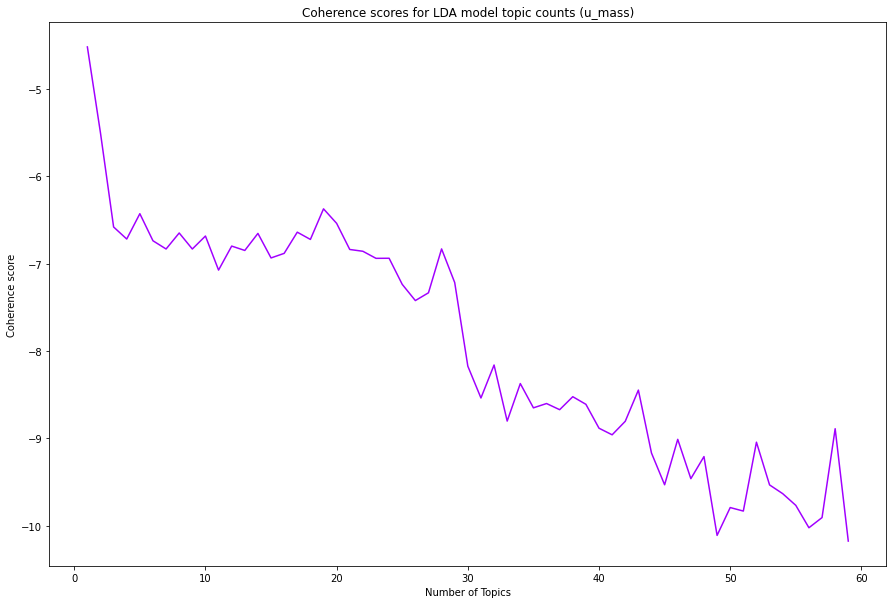

In [146]:
# Show the U-mass coherence results
plt.figure(figsize=(15, 10))
plt.plot(n_topics, score_coherence_umass, color='#a100ff')
plt.title("Coherence scores for LDA model topic counts (u_mass)")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score");

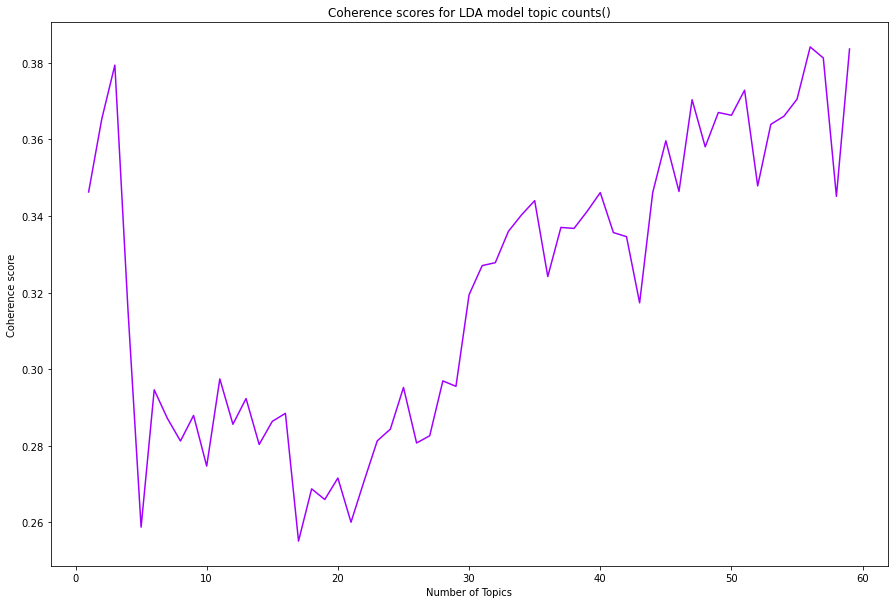

In [147]:
# Show the c_v coherence results
plt.figure(figsize=(15, 10))
plt.plot(n_topics, score_coherence_cv, color='#a100ff')
plt.title("Coherence scores for LDA model topic counts()")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score");

In [51]:
# We will continue with 14 topics since I think it is most optimal amount based on two graphs
num_topics = 14

In [54]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word, 
                                       num_topics=num_topics, random_state=200,
                                       passes=10, workers = 4)

In [55]:
# Compute Coherence Score (u_mass, c_v)
coherence_eval = ['u_mass','c_v']
for i in coherence_eval:
    coherence_model_lda = CoherenceModel(model=lda_model, texts=word_tokens, 
                                     dictionary=id2word, coherence=i)
    coherence_lda = coherence_model_lda.get_coherence()
    print(f'\nCoherence Score {i}: ', coherence_lda)


Coherence Score u_mass:  -7.983235535507256

Coherence Score c_v:  0.4333838155913742


In [56]:
# Count perplexity
print("Perplexity: ", lda_model.log_perplexity(corpus))

Perplexity:  -9.377375337412678


In [57]:
# Print topics and their strength
topics = lda_model.show_topics(num_topics = num_topics, num_words=10, formatted=False)
topics

[(0,
  [('water', 0.015482038),
   ('card', 0.0083263125),
   ('acid', 0.0078575155),
   ('alpha', 0.00718438),
   ('organic', 0.006588544),
   ('chemical', 0.005942154),
   ('element', 0.0057156608),
   ('compound', 0.005502085),
   ('carbon', 0.0051390687),
   ('performance', 0.004712307)]),
 (1,
  [('this', 0.024888923),
   ('article', 0.022323744),
   ('exercise', 0.02011215),
   ('physical', 0.016310753),
   ('analysis', 0.015547017),
   ('cell', 0.011699578),
   ('activity', 0.010457516),
   ('journal', 0.010396085),
   ('effect', 0.009731855),
   ('mass', 0.009581193)]),
 (2,
  [('this', 0.03144837),
   ('student', 0.009152166),
   ('project', 0.008764783),
   ('learning', 0.0069805942),
   ('development', 0.006783875),
   ('guide', 0.0063834907),
   ('technology', 0.006236594),
   ('knowledge', 0.00557516),
   ('science', 0.005326469),
   ('course', 0.0052850954)]),
 (3,
  [('life', 0.009021386),
   ('human', 0.007973657),
   ('verb', 0.007901229),
   ('society', 0.005653678),


In [58]:
# Add the topic number
df_cleaned['topics'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(df_cleaned['abstract']))]
df_cleaned

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                abstract  abstract_length  \
0      chronic lymphocytic leukemia small lymphocytic...               55   
2      karrigell open source python framework written...               53   
7      atherosclerosis previously thought simple lipi...              114   
10     this resource book local history techniques te...              305   
11     this wikibooks fact sheet analysis article hab...              147   
...                                                  ...              ...   
86726  this explores spatial distribution racial grou...              284   
86727  field effect transistors device find applicati...              134   
86728  inquiry oriented activity learners interact co...               68   
86731  welcome python this tutorial show start writin...               56   
86735                       sardine nutritious oily fish               28   

       body_text_length  number_words_abstract  \
0                  4805                      6   
2                  1250                      7   
7                   166                     12   
10                 4408                     40   
11                 8527                     18   
...                 ...                    ...   
86726              1411                     32   
86727              1493                     17   
86728               284                      8   
86731              6672                      8   
86735                49                      4   

                                     abstract_lemmatized  \
0      chronic lymphocytic leukemia small lymphocytic...   
2      karrigell open source python framework written...   
7      atherosclerosis previously thought simple lipi...   
10     this resource book local history technique ter...   
11     this wikibooks fact sheet analysis article hab...   
...                                                  ...   
86726  this explores spatial distribution racial grou...   
86727  field effect transistor device find applicatio...   
86728  inquiry oriented activity learner interact com...   
86731  welcome python this tutorial show start writin...   
86735                       sardine nutritious oily fish   

                                      abstract_tokenized  topics  
0      [chronic, lymphocytic, leukemia, small, lympho...       0  
2      [karrigell, open, source, python, framework, w...       5  
7      [atherosclerosis, previously, thought, simple,...       1  
10     [this, resource, book, local, history, techniq...       2  
11     [this, wikibooks, fact, sheet, analysis, artic...       1  
...                                                  ...     ...  
86726  [this, explores, spatial, distribution, racial...       2  
86727  [field, effect, transistors, device, find, app...       1  
86728  [inquiry, oriented, activity, learners, intera...       2  
86731  [welcome, python, this, tutorial, show, start,...       2  
86735                  [sardine, nutritious, oily, fish]       0  

[37552 rows x 8 columns]

In [59]:
# Show the topic distribution
df_cleaned.topics.value_counts()

0     16218
2      6241
1      4519
5      2629
3      2522
4      1640
6      1187
7       704
8       606
9       504
10      272
11      220
12      199
13       91
Name: topics, dtype: int64

<AxesSubplot:>

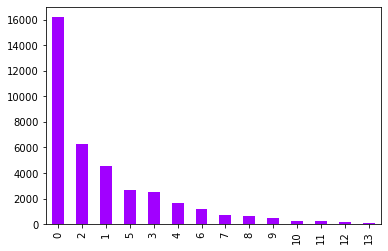

In [69]:
%matplotlib inline
# Plot the topic distribution
df_cleaned.topics.value_counts().plot(kind='bar', label='Distribution of topics', color='#a100ff')

In [70]:
# Add  words for the topic based on topic number
def topic_words(df):
    list_words = []
    counter = 0
    num_topic = df.topics
    for i in topics:
        if (i[0]==num_topic):
            for j in range(0,9):
                list_words.append(topics[counter][1][j][0])
        counter+=1
    return list_words

#add name of the topic based on topic number
def topic_names(df):
    counter = 0
    num_topic = df.topics
    name=''
    for i in range(len(topics)):
        if (num_topic==i):
            name = names_topics[i]
    return name

#to present column for one topic
def present_books(topic_number):
     return df_cleaned[df_cleaned['topics']==topic_number]

In [71]:
# Think of topic names based on the 10 words for the topic
names_topics = ['Biology and geography', 'Chemistry and Physics','History and countries', 
                'General education', 'CSS and extra','IT related', 'Puzzles and logic', 
                'Health and articles', 'Games and PC', 'Health related', 'Games', 
                'Design and Concepts ','Software and development',
               'Language related']
names_topics[:]

['Biology and geography',
 'Chemistry and Physics',
 'History and countries',
 'General education',
 'CSS and extra',
 'IT related',
 'Puzzles and logic',
 'Health and articles',
 'Games and PC',
 'Health related',
 'Games',
 'Design and Concepts ',
 'Software and development',
 'Language related']

In [303]:
# show books of topic 6 
present_books(6)

title  \
98       Historical Geology/Absolute dating: an overview   
134    Mathematics of the Jewish Calendar/The lengths...   
197                     Final Fantasy/Armor/Wooden Armor   
240                                     Trainz/scenarios   
363                       Polish/More on nouns - genders   
...                                                  ...   
86262              Classical Mechanics/Newtonian Physics   
86323  Annotated Republic of China Laws/Act Governing...   
86337  Vibrations of Structures/Introduction to vibra...   
86551  Transportation Systems Simulation - A Tutorial...   
86632                     Horticulture/Spodoptera exigua   

                                                abstract  abstract_length  \
98     article shall take look back methods absolute ...               64   
134    although occurs start month tishri traditional...              182   
197    wooden armor extremely primitive protection wi...              117   
240    become alternative case redirect redirect trai...              136   
363    depending classification chosen either three f...               64   
...                                                  ...              ...   
86262  newton three laws motion basis classical mecha...               80   
86323  case discrepancies chinese english translation...               68   
86337  times terms vibration oscillation without know...              197   
86551  designing vissim network accordance background...              135   
86632  beet armyworm spodoptera exigua agricultural p...              132   

       body_text_length  number_words_abstract  \
98                13038                     10   
134                1995                     23   
197                 786                     17   
240                1440                     18   
363                3051                      8   
...                 ...                    ...   
86262              7984                     10   
86323            107857                      8   
86337              5873                     24   
86551              4497                     16   
86632              3385                     17   

                                     abstract_lemmatized  \
98     article shall take look back method absolute d...   
134    although occurs start month tishri traditional...   
197    wooden armor extremely primitive protection wi...   
240    become alternative case redirect redirect trai...   
363    depending classification chosen either three f...   
...                                                  ...   
86262  newton three law motion basis classical mechan...   
86323  case discrepancy chinese english translation c...   
86337  time term vibration oscillation without knowin...   
86551  designing vissim network accordance background...   
86632  beet armyworm spodoptera exigua agricultural p...   

                                      abstract_tokenized  topics  \
98     [article, shall, take, look, back, methods, ab...       6   
134    [although, occurs, start, month, tishri, tradi...       6   
197    [wooden, armor, extremely, primitive, protecti...       6   
240    [become, alternative, case, redirect, redirect...       6   
363    [depending, classification, chosen, either, th...       6   
...                                                  ...     ...   
86262  [newton, three, laws, motion, basis, classical...       6   
86323  [case, discrepancies, chinese, english, transl...       6   
86337  [times, terms, vibration, oscillation, without...       6   
86551  [designing, vissim, network, accordance, backg...       6   
86632  [beet, armyworm, spodoptera, exigua, agricultu...       6   

                                             topic_words  
98     [puzzle, logic, true, shall, noun, love, solut...  
134    [puzzle, logic, true, shall, noun, love, solut...  
197    [puzzle, logic, true, shall, noun, love, solut...  
240    [puzzle, logic, true, s

In [313]:
# Create new columns based on topic number
df_cleaned['topic_words'] = df_cleaned.apply(topic_words, axis = 1)
df_cleaned['topic_names'] = df_cleaned.apply(topic_names, axis = 1)

df_cleaned

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                abstract  abstract_length  \
0      chronic lymphocytic leukemia small lymphocytic...               55   
2      karrigell open source python framework written...               53   
7      atherosclerosis previously thought simple lipi...              114   
10     resource local history techniques terminology ...              295   
11     wikibooks fact sheet analysis article habitual...              142   
...                                                  ...              ...   
86726  explores spatial distribution racial groups un...              279   
86727  field effect transistors device find applicati...              134   
86728  inquiry oriented activity learners interact co...               68   
86731  welcome python tutorial show start writing pro...               51   
86735                       sardine nutritious oily fish               28   

       body_text_length  number_words_abstract  \
0                  4805                      6   
2                  1250                      7   
7                   166                     12   
10                 4408                     38   
11                 8527                     17   
...                 ...                    ...   
86726              1411                     31   
86727              1493                     17   
86728               284                      8   
86731              6672                      7   
86735                49                      4   

                                     abstract_lemmatized  \
0      chronic lymphocytic leukemia small lymphocytic...   
2      karrigell open source python framework written...   
7      atherosclerosis previously thought simple lipi...   
10     resource local history technique terminology a...   
11     wikibooks fact sheet analysis article habitual...   
...                                                  ...   
86726  explores spatial distribution racial group uni...   
86727  field effect transistor device find applicatio...   
86728  inquiry oriented activity learner interact com...   
86731  welcome python tutorial show start writing pro...   
86735                       sardine nutritious oily fish   

                                      abstract_tokenized  topics  \
0      [chronic, lymphocytic, leukemia, small, lympho...       0   
2      [karrigell, open, source, python, framework, w...       5   
7      [atherosclerosis, previously, thought, simple,...       7   
10     [resource, local, history, techniques, termino...       0   
11     [wikibooks, fact, sheet, analysis, article, ha...       7   
...                                                  ...     ...   
86726  [explores, spatial, distribution, racial, grou...       2   
86727  [field, effect, transistors, device, find, app...       4   
86728  [inquiry, oriented, activity, learners, intera...       3   
86731  [welcome, python, tutorial, show, start, writi...       5   
86735                  [sardine, nutritious, oily, fish]       0   

                                             topic_words  \
0      [plant, family, variation, south, specie, nort...   
2      [program, programming, lesson, function, file,...   
7      [article, exercise, disease, physical, analysi...   
10     [plant, family, var

In [314]:
# Save lda topics
df_cleaned.to_csv('data/df_topics_lda.csv')

In [72]:
# Display scatter plot visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

C:\Users\azizbek.dzheenbekov\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.141382  0.090723       1        1  14.469472
5     -0.192433  0.041686       2        1  12.806964
8     -0.174935 -0.015711       3        1   7.776603
3     -0.001331  0.005694       4        1   7.063122
6     -0.086216 -0.036029       5        1   6.816186
1      0.095420  0.262101       6        1   6.772906
12     0.173105  0.202674       7        1   6.654823
11     0.035581 -0.067974       8        1   6.136212
4      0.063989 -0.016393       9        1   6.111413
7     -0.118702 -0.053925      10        1   5.719238
13     0.036326 -0.126720      11        1   5.301934
9      0.203506 -0.171591      12        1   5.142583
0      0.014800 -0.026656      13        1   4.823089
10     0.092269 -0.087880      14        1   4.405454, topic_info=         Term         Freq        Total Category  logprob  loglift
252     right   887.000000   887.000000  Default  30.0000  30.0000
32    english   900.000000   900.000000  Default  29.0000  29.0000
145      game  1146.000000  1146.000000  Default  28.0000  28.0000
58    article   951.000000   951.000000  Default  27.0000  27.0000
14    disease   821.000000   821.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
51       this    81.375799  4613.893000  Topic14  -5.5173  -0.9154
148      like    61.594162   904.135455  Topic14  -5.7958   0.4359
265     often    57.426128   690.820417  Topic14  -5.8658   0.6349
2359   attack    51.737455   272.010371  Topic14  -5.9701   1.4627
721     style    52.697903   384.738272  Topic14  -5.9518   1.1343

[958 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
11177     10  0.913280  accelerated
390        2  0.960199    accessing
7143       2  0.948128   accomplish
234        7  0.982177   accounting
1380       6  0.017391         acid
...      ...       ...          ...
4061       4  0.067768         york
4061       9  0.914862         york
4148       8  0.976590        zelda
3638      14  0.986108      zuerich
3113      10  0.993979       zurich

[3084 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 6, 9, 4, 7, 2, 13, 12, 5, 8, 14, 10, 1, 11])

### Visualization

In [73]:
# Show the df
df_cleaned

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                                abstract  abstract_length  \
0      chronic lymphocytic leukemia small lymphocytic...               55   
2      karrigell open source python framework written...               53   
7      atherosclerosis previously thought simple lipi...              114   
10     this resource book local history techniques te...              305   
11     this wikibooks fact sheet analysis article hab...              147   
...                                                  ...              ...   
86726  this explores spatial distribution racial grou...              284   
86727  field effect transistors device find applicati...              134   
86728  inquiry oriented activity learners interact co...               68   
86731  welcome python this tutorial show start writin...               56   
86735                       sardine nutritious oily fish               28   

       body_text_length  number_words_abstract  \
0                  4805                      6   
2                  1250                      7   
7                   166                     12   
10                 4408                     40   
11                 8527                     18   
...                 ...                    ...   
86726              1411                     32   
86727              1493                     17   
86728               284                      8   
86731              6672                      8   
86735                49                      4   

                                     abstract_lemmatized  \
0      chronic lymphocytic leukemia small lymphocytic...   
2      karrigell open source python framework written...   
7      atherosclerosis previously thought simple lipi...   
10     this resource book local history technique ter...   
11     this wikibooks fact sheet analysis article hab...   
...                                                  ...   
86726  this explores spatial distribution racial grou...   
86727  field effect transistor device find applicatio...   
86728  inquiry oriented activity learner interact com...   
86731  welcome python this tutorial show start writin...   
86735                       sardine nutritious oily fish   

                                      abstract_tokenized  topics  
0      [chronic, lymphocytic, leukemia, small, lympho...       0  
2      [karrigell, open, source, python, framework, w...       5  
7      [atherosclerosis, previously, thought, simple,...       1  
10     [this, resource, book, local, history, techniq...       2  
11     [this, wikibooks, fact, sheet, analysis, artic...       1  
...                                                  ...     ...  
86726  [this, explores, spatial, distribution, racial...       2  
86727  [field, effect, transistors, device, find, app...       1  
86728  [inquiry, oriented, activity, learners, intera...       2  
86731  [welcome, python, this, tutorial, show, start,...       2  
86735                  [sardine, nutritious, oily, fish]       0  

[37552 rows x 8 columns]

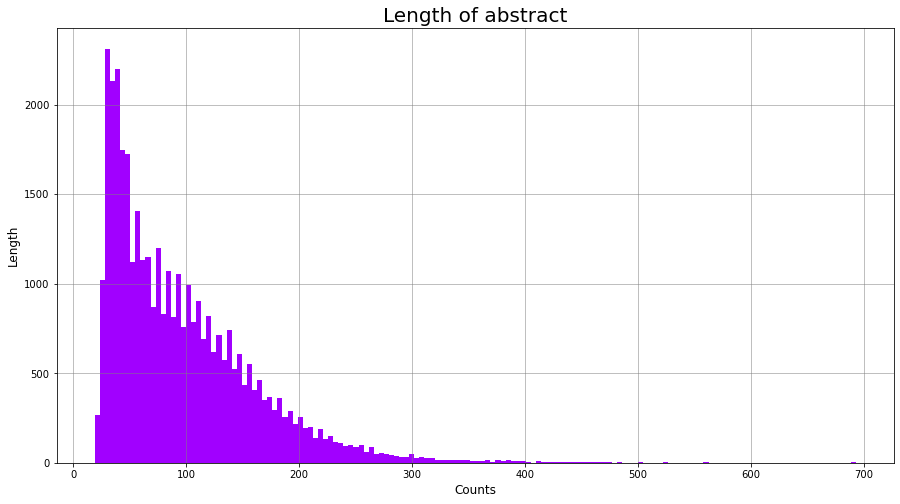

In [74]:
# Plot histogram based on length of abstract
plt.figure()
d = df_cleaned.abstract_length
ax = d.hist( figsize=(15, 8), bins=150,color='#a100ff')
ax.tick_params(axis='x', labelsize=10);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Length', fontsize=12); ax.set_xlabel('Counts', fontsize=12)
ax.set_title('Length of abstract', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

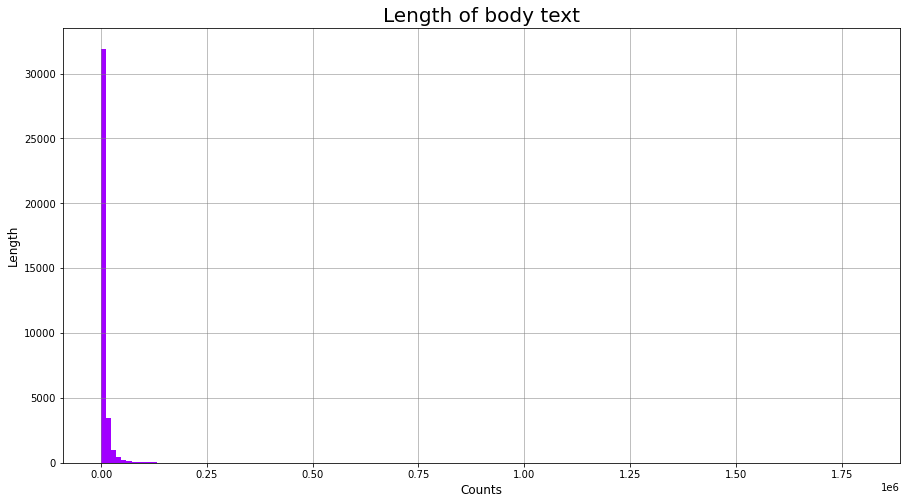

In [75]:
#Plot histogram based on length of body text
plt.figure()
d = df_cleaned.body_text_length
ax = d.hist( figsize=(15, 8), bins=150, color='#a100ff')
ax.tick_params(axis='x', labelsize=10);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Length', fontsize=12); ax.set_xlabel('Counts', fontsize=12)
ax.set_title('Length of body text', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

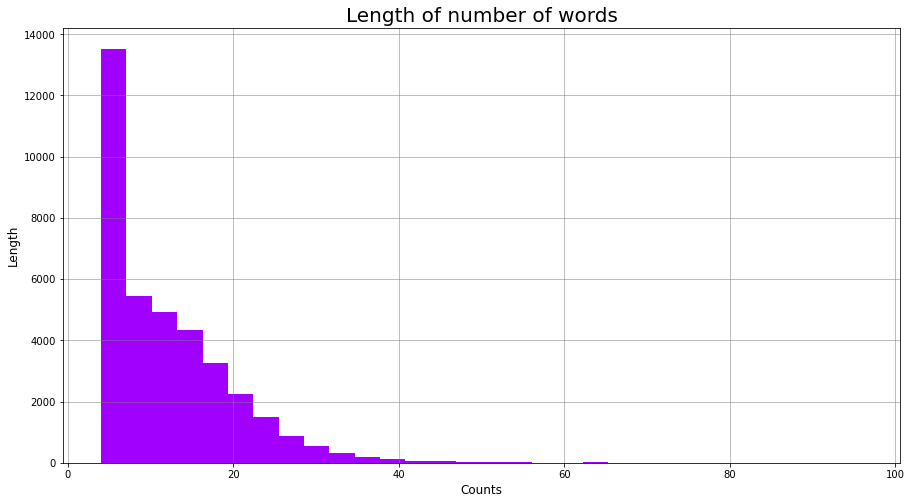

In [76]:
# Plot hist based on number of words 
plt.figure()
d = df_cleaned.number_words_abstract
ax = d.hist( figsize=(15, 8), bins=30, color='#a100ff')
ax.tick_params(axis='x', labelsize=10);ax.tick_params(axis='y', labelsize=10, rotation=0)
ax.set_ylabel('Length', fontsize=12); ax.set_xlabel('Counts', fontsize=12)
ax.set_title('Length of number of words', fontsize=20)
ax.grid(which = "major", color="gray", linewidth=0.5)
plt.show()

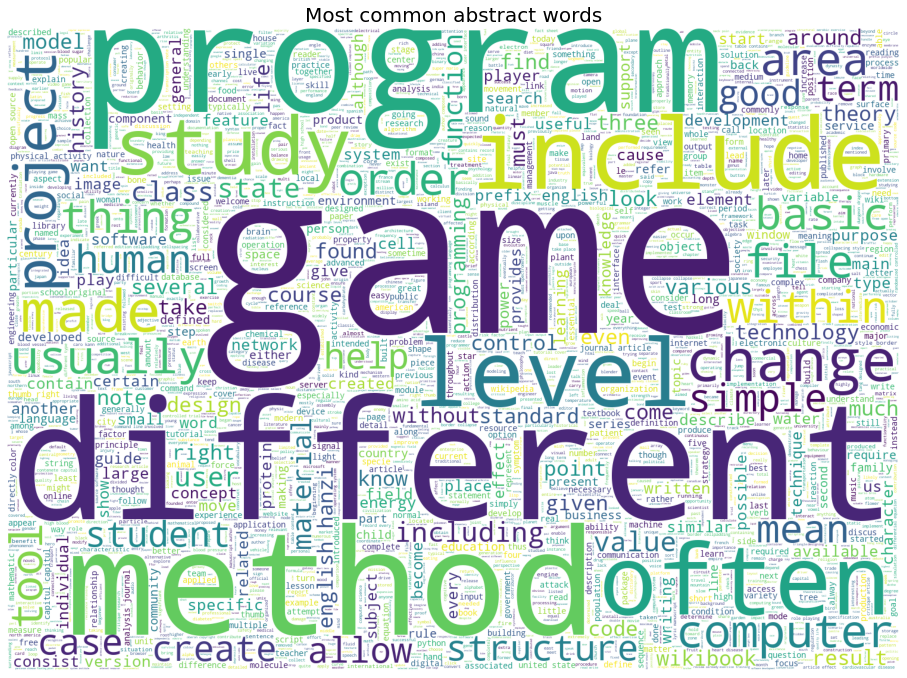

In [324]:
# WordCloud for the most common abstract words
plt.subplots(figsize=(16,13))
wordcloud = WordCloud(
                          background_color='white',max_words = 10000, width=1500, stopwords=STOPWORDS,
                          height=1080).generate(" ".join(df_cleaned.abstract_lemmatized))
plt.title("Most common abstract words", fontsize=20)
plt.imshow(wordcloud.recolor( colormap= 'viridis'))
plt.axis('off')
plt.show()

### LSA

In [77]:
# Create function to create lsa model
def create_gensim_lsa_model(doc_term_matrix, dictionary,number_of_topics,words):
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    topics_10 = lsamodel.print_topics(num_topics=number_of_topics, num_words=10)
    for i in topics_10:
        print(i)
    return lsamodel

In [78]:
# Create LSA Model
model=create_gensim_lsa_model(corpus, id2word, num_topics, word_tokens)

(0, '0.836*"this" + 0.140*"article" + 0.093*"exercise" + 0.091*"game" + 0.082*"analysis" + 0.074*"level" + 0.068*"program" + 0.066*"different" + 0.066*"physical" + 0.065*"study"')
(1, '0.435*"this" + -0.214*"game" + -0.175*"different" + -0.159*"computer" + -0.150*"software" + -0.137*"like" + -0.135*"program" + -0.127*"system" + -0.124*"state" + -0.116*"there"')
(2, '-0.365*"game" + 0.324*"english" + 0.298*"disease" + 0.247*"article" + 0.241*"search" + 0.232*"exercise" + 0.231*"special" + 0.230*"prefix" + 0.212*"blood" + 0.209*"hanzi"')
(3, '-0.472*"english" + -0.344*"search" + -0.329*"special" + -0.326*"prefix" + -0.295*"hanzi" + -0.231*"game" + 0.203*"disease" + 0.183*"article" + 0.142*"exercise" + -0.130*"this"')
(4, '0.765*"game" + 0.190*"disease" + 0.153*"article" + -0.151*"software" + 0.135*"exercise" + 0.130*"blood" + 0.114*"player" + -0.108*"system" + -0.104*"open" + -0.096*"project"')
(5, '0.307*"article" + -0.304*"blood" + 0.284*"software" + 0.271*"program" + -0.175*"state" + 

## Corex

In [79]:
# Train the CorEx topic model
topic_model = ct.Corex(n_hidden=num_topics, words=words_vect, max_iter=5000, verbose=False, seed=2020)
topic_model.fit(abstract_vectorized, words=words_vect)

In [80]:
# Get topics and show then
topics = topic_model.get_topics()
topics

[[('disease', 0.05201634061238762, 1.0),
  ('prefix', 0.03696553629626281, 1.0),
  ('blood', 0.03627618528510246, 1.0),
  ('special', 0.034840267463932685, 1.0),
  ('hanzi', 0.03412385614275007, 1.0),
  ('search', 0.03289090693566595, 1.0),
  ('exercise', 0.02661556522699407, 1.0),
  ('risk', 0.017232037786821912, 1.0),
  ('patient', 0.01503487265618864, 1.0),
  ('english', 0.015011669818016146, 1.0)],
 [('united', 0.02561929576914935, 1.0),
  ('state', 0.022148333136924825, 1.0),
  ('south', 0.021022877607422188, 1.0),
  ('north', 0.01978048878006905, 1.0),
  ('country', 0.014946441858893881, 1.0),
  ('century', 0.014325717063454107, 1.0),
  ('america', 0.01366643587502247, 1.0),
  ('asia', 0.013366891489264345, 1.0),
  ('europe', 0.012803414700136257, 1.0),
  ('china', 0.012704128156754152, 1.0)],
 [('article', 0.05194278779663188, 1.0),
  ('journal', 0.030426801717503855, 1.0),
  ('analysis', 0.0254217082965964, 1.0),
  ('physical', 0.022169576128795727, 1.0),
  ('activity', 0.02077

In [81]:
# w: word, mi: mutual information, s: sign
# Unpack the info about the topic
# Print topic
for topic_n,topic in enumerate(topics):
    topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic]
    words,mis,signs = zip(*topic)    
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)

1: disease, prefix, blood, special, hanzi, search, exercise, risk, patient, english
2: united, state, south, north, country, century, america, asia, europe, china
3: article, journal, analysis, physical, activity, critique, student, research, study, training
4: this, programming, software, user, file, program, code, tutorial, module, computer
5: even, like, often, would, much, however, although, good, thing, though
6: molecule, protein, energy, chemical, reaction, cell, mass, electron, atom, chemistry
7: mario, fantasy, super, dragon, spell, white, dungeon, enemy, magic, black
8: plant, verb, specie, genus, noun, capitul, contenete, native, family, fruit
9: game, player, video, role, playing, company, business, service, play, card
10: technology, science, mathematics, theory, mathematical, information, engineering, concept, management, problem
11: equation, output, input, variable, value, function, signal, device, circuit, differential
12: different, word, lesson, learn, there, languag

0: disease,prefix,blood,special,hanzi,search,exercise,risk,patient,english
1: united,state,south,north,country,century,america,asia,europe,china
2: article,journal,analysis,physical,activity,critique,student,research,study,training
3: this,programming,software,user,file,program,code,tutorial,module,computer
4: even,like,often,would,much,however,although,good,thing,though
5: molecule,protein,energy,chemical,reaction,cell,mass,electron,atom,chemistry
6: mario,fantasy,super,dragon,spell,white,dungeon,enemy,magic,black
7: plant,verb,specie,genus,noun,capitul,contenete,native,family,fruit
8: game,player,video,role,playing,company,business,service,play,card
9: technology,science,mathematics,theory,mathematical,information,engineering,concept,management,problem
10: equation,output,input,variable,value,function,signal,device,circuit,differential
11: different,word,lesson,learn,there,language,way,meaning,grammar,write
12: line,point,given,command,position,simple,screen,size,length,move
13: vari

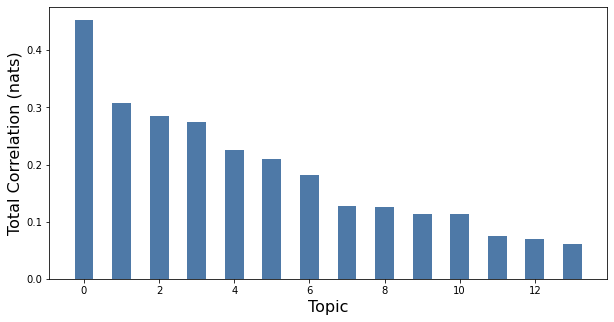

In [82]:
# plot overall topic scores
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

topics = topic_model.get_topics()
topic_list = []

for n,topic in enumerate(topics):
    topic_words, mis, signs = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))
    topic_list.append('topic_' + str(n) + ': ' + ', '.join(topic_words))

In [83]:
# Show visualization of topics
vt.vis_rep(topic_model, column_label=words_vect, prefix='topic-model-example')

Print topics in text file


C:\ProgramData\Anaconda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


In [84]:
# Create the df with certain columns
df_corex = df_cleaned[['title','abstract_lemmatized', 'abstract_tokenized']]
df_corex

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                     abstract_lemmatized  \
0      chronic lymphocytic leukemia small lymphocytic...   
2      karrigell open source python framework written...   
7      atherosclerosis previously thought simple lipi...   
10     this resource book local history technique ter...   
11     this wikibooks fact sheet analysis article hab...   
...                                                  ...   
86726  this explores spatial distribution racial grou...   
86727  field effect transistor device find applicatio...   
86728  inquiry oriented activity learner interact com...   
86731  welcome python this tutorial show start writin...   
86735                       sardine nutritious oily fish   

                                      abstract_tokenized  
0      [chronic, lymphocytic, leukemia, small, lympho...  
2      [karrigell, open, source, python, framework, w...  
7      [atherosclerosis, previously, thought, simple,...  
10     [this, resource, book, local, history, techniq...  
11     [this, wikibooks, fact, sheet, analysis, artic...  
...                                                  ...  
86726  [this, explores, spatial, distribution, racial...  
86727  [field, effect, transistors, device, find, app...  
86728  [inquiry, oriented, activity, learners, intera...  
86731  [welcome, python, this, tutorial, show, start,...  
86735                  [sardine, nutritious, oily, fish]  

[37552 rows x 3 columns]

In [85]:
# CorEx stores the likelihood scores 
for topic_num in range(0, len(topics)):
    df_corex['topic_' + str(topic_num)] = topic_model.log_p_y_given_x[:,topic_num]


In [86]:
df_corex

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                     abstract_lemmatized  \
0      chronic lymphocytic leukemia small lymphocytic...   
2      karrigell open source python framework written...   
7      atherosclerosis previously thought simple lipi...   
10     this resource book local history technique ter...   
11     this wikibooks fact sheet analysis article hab...   
...                                                  ...   
86726  this explores spatial distribution racial grou...   
86727  field effect transistor device find applicatio...   
86728  inquiry oriented activity learner interact com...   
86731  welcome python this tutorial show start writin...   
86735                       sardine nutritious oily fish   

                                      abstract_tokenized       topic_0  \
0      [chronic, lymphocytic, leukemia, small, lympho... -3.206703e-01   
2      [karrigell, open, source, python, framework, w... -6.281367e+00   
7      [atherosclerosis, previously, thought, simple,... -1.657033e-08   
10     [this, resource, book, local, history, techniq... -6.099815e+00   
11     [this, wikibooks, fact, sheet, analysis, artic... -2.617590e-03   
...                                                  ...           ...   
86726  [this, explores, spatial, distribution, racial... -3.659244e+00   
86727  [field, effect, transistors, device, find, app... -6.281367e+00   
86728  [inquiry, oriented, activity, learners, intera... -6.281367e+00   
86731  [welcome, python, this, tutorial, show, start,... -6.281367e+00   
86735                  [sardine, nutritious, oily, fish] -6.281367e+00   

            topic_1       topic_2   topic_3   topic_4   topic_5   topic_6  \
0     -5.635104e+00 -6.841252e+00 -4.184455 -2.072033 -5.468832 -5.520677   
2     -5.635104e+00 -5.333165e+00 -0.001683 -3.354660 -5.468832 -5.520678   
7     -5.635104e+00 -6.841252e+00 -4.184455 -0.036810 -5.468816 -5.520678   
10    -1.227596e-02 -9.898364e-03 -0.374389 -0.000003 -5.468815 -5.520678   
11    -5.635104e+00 -1.463363e-11 -2.827868 -3.354660 -5.468832 -5.520678   
...             ...           ...       ...       ...       ...       ...   
86726 -1.193143e-09 -4.462270e-01 -0.016322 -0.011057 -4.347133 -5.520678   
86727 -5.635104e+00 -1.301329e+00 -2.126667 -0.386824 -2.416730 -5.520678   
86728 -5.635104e+00 -9.136189e-01 -1.370709 -1.834946 -5.468830 -5.520692   
86731 -5.635104e+00 -6.841250e+00 -0.000831 -3.354660 -5.468832 -5.520678   
86735 -5.635104e+00 -6.841252e+00 -4.184455 -3.354660 -5.468832 -5.520678   

        topic_7   topic_8   topic_9      topic_10  topic_11  topic_12  \
0     -5.568441 -3.838038 -3.244021 -3.608511e+00 -3.247754 -2.735483   
2     -5.568486 -3.838040 -3.244011 -3.608509e+00 -3.247700 -2.736285   
7     -5.568507 -3.838032 -3.242360 -1.860418e-02 -3.247476 -1.245948   
10    -0.203731 -2.293921 -0.464536 -3.608577e+00 -0.000602 -2.736468   
11    -5.568537 -3.838045 -3.243977 -3.608525e+00 -3.247913 -2.737557   
...         ...       ...       ...           ...       ...       ...   
86726 -5.568762 -0.011200 -1.878715 -1.931250e-01 -3.246369 -2.735791   
86727 -5.568490 -3.838034 -3.243183 -1.133822e-10 -3.247001 -2.734290   
86728 -5.568734 -3.835239 -0.047071 -3.608402e+00 -3.244978 -2.735709   
86731 -5.568525 -3.838029 -3.243983 -3.608497e+00 -0.496621 -0.68

In [87]:
# Create a column for the best topic
# "best_topic" column is the highest scoring topic for a row.
corex_cols = [col for col in df_corex if col.startswith('topic_')]
df_corex['best_topic'] = df_corex[corex_cols].idxmax(axis=1)

In [88]:
# Get the topics distribution
df_corex['best_topic'].value_counts()

topic_4     6186
topic_3     5318
topic_12    4015
topic_9     3367
topic_0     2951
topic_1     2605
topic_10    2358
topic_8     2271
topic_11    2211
topic_5     1931
topic_6     1683
topic_2     1347
topic_7     1039
topic_13     270
Name: best_topic, dtype: int64

<AxesSubplot:>

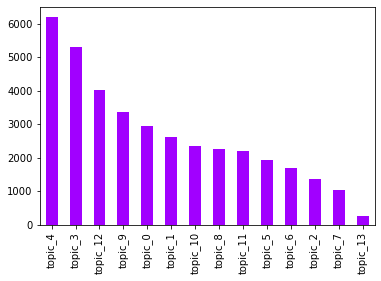

In [89]:
# Plot the topics distribution using bar plot
df_corex.best_topic.value_counts().plot(kind='bar', label='Distribution of topics', color='#a100ff')

In [90]:
# Show the df
df_corex

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
2                                              Karrigell   
7      English-Hanzi/Atherosclerosis involves inflamm...   
10     A Researcher's Guide to Local History Terminology   
11     Exercise as it relates to Disease/The Benefits...   
...                                                  ...   
86726             Geography of Race in the United States   
86727  Semiconductor Electronics/Field Effect Transis...   
86728                   Life in the Open Ocean/Webquests   
86731        Python Programming/Creating Python Programs   
86735    English-Hanzi/Sardine is a nutritious oily fish   

                                     abstract_lemmatized  \
0      chronic lymphocytic leukemia small lymphocytic...   
2      karrigell open source python framework written...   
7      atherosclerosis previously thought simple lipi...   
10     this resource book local history technique ter...   
11     this wikibooks fact sheet analysis article hab...   
...                                                  ...   
86726  this explores spatial distribution racial grou...   
86727  field effect transistor device find applicatio...   
86728  inquiry oriented activity learner interact com...   
86731  welcome python this tutorial show start writin...   
86735                       sardine nutritious oily fish   

                                      abstract_tokenized       topic_0  \
0      [chronic, lymphocytic, leukemia, small, lympho... -3.206703e-01   
2      [karrigell, open, source, python, framework, w... -6.281367e+00   
7      [atherosclerosis, previously, thought, simple,... -1.657033e-08   
10     [this, resource, book, local, history, techniq... -6.099815e+00   
11     [this, wikibooks, fact, sheet, analysis, artic... -2.617590e-03   
...                                                  ...           ...   
86726  [this, explores, spatial, distribution, racial... -3.659244e+00   
86727  [field, effect, transistors, device, find, app... -6.281367e+00   
86728  [inquiry, oriented, activity, learners, intera... -6.281367e+00   
86731  [welcome, python, this, tutorial, show, start,... -6.281367e+00   
86735                  [sardine, nutritious, oily, fish] -6.281367e+00   

            topic_1       topic_2   topic_3   topic_4   topic_5   topic_6  \
0     -5.635104e+00 -6.841252e+00 -4.184455 -2.072033 -5.468832 -5.520677   
2     -5.635104e+00 -5.333165e+00 -0.001683 -3.354660 -5.468832 -5.520678   
7     -5.635104e+00 -6.841252e+00 -4.184455 -0.036810 -5.468816 -5.520678   
10    -1.227596e-02 -9.898364e-03 -0.374389 -0.000003 -5.468815 -5.520678   
11    -5.635104e+00 -1.463363e-11 -2.827868 -3.354660 -5.468832 -5.520678   
...             ...           ...       ...       ...       ...       ...   
86726 -1.193143e-09 -4.462270e-01 -0.016322 -0.011057 -4.347133 -5.520678   
86727 -5.635104e+00 -1.301329e+00 -2.126667 -0.386824 -2.416730 -5.520678   
86728 -5.635104e+00 -9.136189e-01 -1.370709 -1.834946 -5.468830 -5.520692   
86731 -5.635104e+00 -6.841250e+00 -0.000831 -3.354660 -5.468832 -5.520678   
86735 -5.635104e+00 -6.841252e+00 -4.184455 -3.354660 -5.468832 -5.520678   

        topic_7   topic_8   topic_9      topic_10  topic_11  topic_12  \
0     -5.568441 -3.838038 -3.244021 -3.608511e+00 -3.247754 -2.735483   
2     -5.568486 -3.838040 -3.244011 -3.608509e+00 -3.247700 -2.736285   
7     -5.568507 -3.838032 -3.242360 -1.860418e-02 -3.247476 -1.245948   
10    -0.203731 -2.293921 -0.464536 -3.608577e+00 -0.000602 -2.736468   
11    -5.568537 -3.838045 -3.243977 -3.608525e+00 -3.247913 -2.737557   
...         ...       ...       ...           ...       ...       ...   
86726 -5.568762 -0.011200 -1.878715 -1.931250e-01 -3.246369 -2.735791   
86727 -5.568490 -3.838034 -3.243183 -1.133822e-10 -3.247001 -2.734290   
86728 -5.568734 -3.835239 -0.047071 -3.608402e+00 -3.244978 -2.735709   
86731 -5.568525 -3.838029 -3.243983 -3.608497e+00 -0.496621 -0.68

In [91]:
# Get the words for topic 0
print(topic_list[0])

topic_0: disease, prefix, blood, special, hanzi, search, exercise, risk, patient, english


In [92]:
# Get the books for topic 0
df_corex[df_corex['best_topic']== 'topic_0']

title  \
0                         Radiation Oncology/NHL/CLL-SLL   
7      English-Hanzi/Atherosclerosis involves inflamm...   
16                English-Hanzi/Eosinophilic myocarditis   
29     English-Hanzi/Obesity is a known and very impo...   
35     Energy Efficiency Reference/Refrigeration/Reco...   
...                                                  ...   
86536  English-Hanzi/Intracranial aneurisms are the m...   
86594                         English-Hanzi/Carbohydrate   
86625  Traditional Chinese Medicine/Formula Design/Cl...   
86654  English-Hanzi/Arterial calcification is a grad...   
86703     English-Hanzi/What causes high blood pressure?   

                                     abstract_lemmatized  \
0      chronic lymphocytic leukemia small lymphocytic...   
7      atherosclerosis previously thought simple lipi...   
16     eosinophilic myocarditis inflammation heart mu...   
29     obesity risk factor development osteoarthritis...   
35     compressor power decrease pressure difference ...   
...                                                  ...   
86536  intracranial aneurism main cause bleeding arou...   
86594   special search carbohydrate prefix english hanzi   
86625  formula designed warm cool simultaneously calm...   
86654  arterial calcification gradual development occ...   
86703          special search blood prefix english hanzi   

                                      abstract_tokenized       topic_0  \
0      [chronic, lymphocytic, leukemia, small, lympho... -3.206703e-01   
7      [atherosclerosis, previously, thought, simple,... -1.657033e-08   
16     [eosinophilic, myocarditis, inflammation, hear... -1.302801e-08   
29     [obesity, risk, factor, development, osteoarth... -1.090523e-10   
35     [compressor, power, decreases, pressure, diffe... -4.604297e-02   
...                                                  ...           ...   
86536  [intracranial, aneurisms, main, cause, bleedin... -5.631128e-07   
86594  [special, search, carbohydrate, prefix, englis... -1.553691e-11   
86625  [formula, designed, warm, cool, simultaneously... -4.464664e-08   
86654  [arterial, calcification, gradual, development... -2.126299e-12   
86703   [special, search, blood, prefix, english, hanzi] -1.548095e-12   

        topic_1   topic_2   topic_3   topic_4   topic_5   topic_6   topic_7  \
0     -5.635104 -6.841252 -4.184455 -2.072033 -5.468832 -5.520677 -5.568441   
7     -5.635104 -6.841252 -4.184455 -0.036810 -5.468816 -5.520678 -5.568507   
16    -5.635104 -3.569062 -4.184455 -3.354660 -2.615553 -0.381106 -5.568486   
29    -5.635104 -6.841252 -4.184455 -2.040525 -5.468832 -5.520678 -5.568489   
35    -5.635104 -6.841252 -1.243864 -0.232597 -0.243195 -5.520678 -5.568484   
...         ...       ...       ...       ...       ...       ...       ...   
86536 -5.635104 -6.841252 -4.184455 -0.923006 -5.468831 -5.520678 -5.568492   
86594 -5.635104 -6.841252 -4.184455 -3.354660 -5.468831 -5.520678 -5.568485   
86625 -5.635104 -6.841252 -4.184455 -3.354660 -5.468832 -5.520678 -2.586115   
86654 -5.635104 -6.841252 -4.184455 -1.664057 -1.993546 -5.520677 -5.568399   
86703 -5.635104 -6.841252 -4.184455 -3.354660 -5.468832 -5.520678 -5.568487   

        topic_8   topic_9  topic_10  topic_11  topic_12  topic_13 best_topic  
0     -3.838038 -3.244021 -3.608511 -3.247754 -2.735483 -9.901890    topic_0  
7     -3.838032 -3.242360 -0.018604 -3.247476 -1.245948 -9.947791    topic_0  
16    -3.838042 -3.244021 -3.608510 -3.248236 -2.736576 -9.899936    topic_0  
29    -3.838045 -1.743776 -3.608538 -3.248675 -2.737973 -9.901567    topic_0  
35    -3.838050 -0.784430 -3.608304 -1.859978 -0.238124 -9.922273    topic_0  
...         ...       ...       ...       ...       ...       ...        ...  
86536 -3.838028 -3.243898 -3.606801 -3.247543 -0.767601 -9.903649    topic_0  
86594 -3.838047 -3.244041 -3.608538 -3.249183 -2.738082 -9.899816    topic_0  
86625 -3.838030 -3.243927 -3.608437 -3.247981 -1.008006 -9.9

In [93]:
# Get the words for topic 5
print(topic_list[5])

topic_5: molecule, protein, energy, chemical, reaction, cell, mass, electron, atom, chemistry


In [94]:
# Get the books for topic 5
df_corex[df_corex['best_topic']== 'topic_5']

title  \
141                  Introduction to Inorganic Chemistry   
184                                      Flying the Disc   
205           Inorganic Chemistry/Coordination Chemistry   
275    OCR Advanced GCE in Chemistry/Electrode potent...   
355    Sport Innovation/Power Plate® powerBIKE™/Metho...   
...                                                  ...   
86570                          Climatology/Precipitation   
86576  Structural Biochemistry/Organic Chemistry/Meth...   
86578  Structural Biochemistry/Proteins are modified ...   
86695         Mechanical Vibration/Vibrational Resonance   
86714      A hand book of life sciences/EXCRETORY SYSTEM   

                                     abstract_lemmatized  \
141    inorganic chemistry study synthesis reaction s...   
184    flying disc including frisbee thrown way invol...   
205    coordination chemistry aspect inorganic chemis...   
275    electrochemical cell exothermic reaction half ...   
355                          method whole body vibration   
...                                                  ...   
86570  precipitation falling water different form the...   
86576  combustion analysis elemental analysis oldest ...   
86578  protein modified fatty acid cysteine residue i...   
86695  vibration frequency external force equal natur...   
86714  removal harmful unwanted waste material excret...   

                                      abstract_tokenized   topic_0   topic_1  \
141    [inorganic, chemistry, study, synthesis, react... -6.281367 -4.490162   
184    [flying, discs, including, frisbees, thrown, w... -6.281367 -5.635104   
205    [coordination, chemistry, aspect, inorganic, c... -6.281367 -5.635104   
275    [electrochemical, cell, exothermic, reaction, ... -6.281367 -3.998685   
355                     [method, whole, body, vibration] -6.281367 -5.635104   
...                                                  ...       ...       ...   
86570  [precipitation, falling, water, different, for... -6.281367 -3.650050   
86576  [combustion, analysis, elemental, analysis, ol... -1.608987 -3.574562   
86578  [proteins, modified, fatty, acid, cysteine, re... -3.308305 -5.635104   
86695  [vibration, frequency, external, force, equal,... -3.078851 -5.635104   
86714  [removal, harmful, unwanted, waste, material, ... -3.993484 -5.635104   

        topic_2    topic_3       topic_4   topic_5   topic_6    topic_7  \
141   -0.000588  -0.388079 -9.985528e-10  0.000000 -5.520652  -5.567102   
184   -6.841252  -4.184455 -7.113017e-01 -0.216614 -2.072653  -5.568497   
205   -6.841252 -12.114417 -3.354660e+00 -0.023614 -5.520678  -5.568502   
275   -6.841252  -4.184455 -1.982787e+00 -0.004991 -5.520672  -5.568376   
355   -6.841252  -4.184455 -2.074246e+00 -1.203281 -5.520678  -5.568473   
...         ...        ...           ...       ...       ...        ...   
86570 -6.841252 -12.158907 -1.589823e+00 -0.153470 -3.822335  -5.565497   
86576 -1.491174  -4.184455 -4.258685e-06  0.000000 -3.367402  -5.568433   
86578 -6.841250  -2.821141 -2.369753e+00 -0.008210 -5.520678 -15.326057   
86695 -6.841252  -4.184445 -1.985728e-01 -0.000175 -5.520681  -5.568267   
86714 -5.723101  -4.184455 -1.435568e+00 -0.897652 -5.520679  -3.650388   

        topic_8       topic_9  topic_10  topic_11  topic_12   topic_13  \
141   -3.838021 -6.981048e-07 -0.000096 -3.244242 -0.322983 -10.157434   
184   -2.116952 -3.243662e+00 -0.845152 -0.483670 -1.735252  -9.958686   
205   -3.838056 -4.636485e-01 -3.608376 -3.247044 -1.363214  -9.921957   
275   -1.525472 -3.244106e+00 -1.698214 -3.243512 -0.394264  -9.993593   
355   -3.838046 -1.772123e+00 -3.608371 -3.247196 -2.733824  -9.918866   
...         ...           ...       ...       ...       ...        ...   
86570 -3.838063 -3.244009e+00 -3.608557 -0.532256 -2.732908  -9.953224   
86576 -3.838038 -1.770975e+00 -0.881980 -3.247913 -2.730999  -9.967704   
86578 -3.837579 -9.178059e-01 -0.039291 -2.055898 -2.736661  -9.919783   
86695 -

In [95]:
# Get the words for topic 10
print(topic_list[10])

topic_10: equation, output, input, variable, value, function, signal, device, circuit, differential


In [96]:
# Get the books for topic 10
df_corex[df_corex['best_topic']== 'topic_10']

title  \
28     A-level Computing/WJEC (Eduqas)/Component 2/Ha...   
33            How To Build a Pinewood Derby Car/Glossary   
136          XQuery/DBpedia with SPARQL - Football teams   
189        Transportation Deployment Casebook/Trolleybus   
204                             Brlcad/How to mged/units   
...                                                  ...   
86649  Jeep Liberty/Limited Slips/Auburn High Perform...   
86679                     Physics Exercises/Heat Engines   
86694                   Programming for Palm OS/C/Fields   
86722  Logic for Computer Scientists/Predicate Logic/...   
86727  Semiconductor Electronics/Field Effect Transis...   

                                     abstract_lemmatized  \
28     central processing unit performs instruction h...   
33     alignment aligning wheel vertically angle camb...   
136    dbpedia project convert content wikipedia link...   
189    trolleybus electrically powered bus unlike ele...   
204    unit command output current unit distance meas...   
...                                                  ...   
86649  auburn high performance limited slip different...   
86679  steam power plant steam engine pair heat outpu...   
86694                         field described pilrc like   
86722               selective linear definite resolution   
86727  field effect transistor device find applicatio...   

                                      abstract_tokenized    topic_0   topic_1  \
28     [central, processing, unit, performs, instruct...  -6.281367 -3.420901   
33     [alignment, aligning, wheel, vertically, angle...  -6.281367 -5.635104   
136    [dbpedia, project, convert, contents, wikipedi... -16.414486 -5.635104   
189    [trolleybuses, electrically, powered, buses, u...  -6.281367 -3.799772   
204    [units, command, output, current, units, dista...  -6.281367 -5.635104   
...                                                  ...        ...       ...   
86649  [auburn, high, performance, limited, slip, dif...  -4.537946 -5.635104   
86679  [steam, power, plant, steam, engines, pairs, h...  -6.281367 -5.635104   
86694                   [fields, described, pilrc, like]  -6.281367 -5.635104   
86722          [selective, linear, definite, resolution]  -6.281367 -5.635104   
86727  [field, effect, transistors, device, find, app...  -6.281367 -5.635104   

        topic_2   topic_3   topic_4   topic_5   topic_6   topic_7   topic_8  \
28    -6.841252 -0.000198 -0.056605 -5.468831 -5.520678 -5.568508 -3.837985   
33    -6.841252 -4.184455 -0.966989 -5.468832 -3.858743 -5.568485 -3.838040   
136   -6.841252 -2.470889 -7.029164 -4.279375 -5.520678 -5.568493 -3.838031   
189   -6.841252 -2.347975 -0.007147 -5.468832 -5.520677 -5.568930 -2.212495   
204   -6.841252 -4.184454 -3.354660 -5.468831 -5.520678 -5.568501 -3.838041   
...         ...       ...       ...       ...       ...       ...       ...   
86649 -5.064827 -4.184455 -1.931131 -5.468832 -5.520678 -5.568503 -3.837977   
86679 -6.841252 -0.957407 -2.194190 -0.169796 -4.314218 -1.369581 -2.292154   
86694 -6.841252 -4.184455 -1.525789 -5.468831 -5.520678 -5.568485 -3.838040   
86722 -6.841252 -4.184455 -3.354660 -5.468832 -5.520678 -3.137415 -3.838040   
86727 -1.301329 -2.126667 -0.386824 -2.416730 -5.520678 -5.568490 -3.838034   

        topic_9      topic_10  topic_11  topic_12   topic_13 best_topic  
28    -3.243756 -1.091675e-05 -3.246281 -1.224874  -9.999041   topic_10  
33    -3.244014 -2.974594e-01 -3.247709 -2.736321  -9.880605   topic_10  
136   -3.243807 -1.415372e+00 -3.247758 -2.737107  -9.898354   topic_10  
189   -3.241788 -4.075029e-03 -3.248113 -0.004963 -10.065068   topic_10  
204   -3.244006 -2.246180e-06 -3.247810 -0.115930  -9.911132   topic_10  
...         ...           ...       ...       ...        ...        ...  
86649 -3.243688 -7.494484e-05 -3.247742 -2.736355  -9.888583   topic_10  
86679 -3.244012 -4.033469e-05 -3.248014 -2.724415  -9.911867   topic_10  
86694 -3.243196 -1.03